# DATASET HISTÓRICO. PREDICCIÓN DE VOLÚMENES DE CARGAS.

In [ ]:
import pandas as pd
import numpy as np
import csv
import copy
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import requests
from sklearn.preprocessing import StandardScaler as ss
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
import re
from scipy.stats import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pickle

In [ ]:
df_historico = pd.read_csv(r"C:\Users\usuario\Documents\TFM\datos\Historico.csv")

In [ ]:
df_historico.head()

,id_orden,fecha_real_carga,id_tipo_transporte,incoterms,region_origen,provincia_origen,id_pais_origen,region_destino_final,provincia_destino_final,id_pais_destino,numero_pales,incidencia
0,OCZ0671450,2022-02-25 09:46:00.000,1,DAP,30,Murcia,ES,19,Guadalajara,ES,33,False
1,OCZ0691381,2022-06-20 08:58:00.000,1,DAP,30,Murcia,ES,7,Baleares,ES,33,False
2,OCZ0737222,2023-02-22 16:35:00.000,3,DAP,30,Murcia,ES,41,Sevilla,ES,33,False
3,OCZ0816341,2024-04-26 05:12:00.000,3,DAP,30,Murcia,ES,46,Valencia,ES,33,False
4,OCZ0818124,2024-05-30 08:22:00.000,3,DAP,30,Murcia,ES,28,Madrid,ES,33,False


## 1. Análisis Exploratorio de Datos (EDA)

In [ ]:
#Numero de columnas y filas
df_historico.shape

(24435, 12)

- Hay 24.435 registros en el dataset de Histórico

- Hay 12 columnas en el dataset de Histórico

In [ ]:
#Descripción general del dataset

df_historico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24435 entries, 0 to 24434
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id_orden                 24435 non-null  object
 1   fecha_real_carga         24435 non-null  object
 2   id_tipo_transporte       24435 non-null  int64 
 3   incoterms                24435 non-null  object
 4   region_origen            24435 non-null  int64 
 5   provincia_origen         24435 non-null  object
 6   id_pais_origen           24435 non-null  object
 7   region_destino_final     24435 non-null  int64 
 8   provincia_destino_final  24435 non-null  object
 9   id_pais_destino          24435 non-null  object
 10  numero_pales             24435 non-null  int64 
 11  incidencia               24435 non-null  bool  
dtypes: bool(1), int64(4), object(7)
memory usage: 2.1+ MB


In [ ]:
#Verificación de valores nulos

df_historico.isnull().sum()

id_orden                   0
fecha_real_carga           0
id_tipo_transporte         0
incoterms                  0
region_origen              0
provincia_origen           0
id_pais_origen             0
region_destino_final       0
provincia_destino_final    0
id_pais_destino            0
numero_pales               0
incidencia                 0
dtype: int64

**No hay valores nulos** en el dataset Histórico

In [ ]:
#Revisión de duplicados

df_historico.duplicated().sum()

0

**No hay registros duplicados** en el dataset Histórico

In [ ]:
#Verificación de valores únicos en cada variable del dataset
df_historico.nunique()

id_orden                   24435
fecha_real_carga           23795
id_tipo_transporte             4
incoterms                      1
region_origen                  1
provincia_origen               1
id_pais_origen                 1
region_destino_final          30
provincia_destino_final       30
id_pais_destino                1
numero_pales                  33
incidencia                     2
dtype: int64

Observaciones:

- El idenficador **id_orden** es único, lo cual es esperado ya que cada envío debería tener un identificador único. Esta variable puede ser útil para contabilizar el número de envíos.

- Hay **23,795 fechas únicas**. Esto sugiere que en algunos casos, podría haber múltiples envíos realizados en el mismo día y hora, lo cual puede ser razonable dependiendo del contexto.
  
- Solo hay **4 tipos de transporte** únicos, a pesar de que debería haber más según la descripción de los datos (se mencionaron al menos 9 tipos de transporte diferentes). Esto podría indicar que algunos tipos de transporte no están presentes en los datos porque no se trabaja con ellos o que hubo alguna consolidación.
  
- Hay **un único valor de la variable incoterms**, por tanto más adelante se eliminará esta variable ya que no contribuye a la variabilidad en los datos.
  
- Hay **una única region, provincia y país de origen**. El país de origen se eliminará ya que no contribuye a la variabilidad en los datos. En cuanto a la región y provincia de origen se comprobará si representan lo mismo para eliminar alguna en caso de que no aporten información diferente.
  
- Hay **30 regiones y provincias diferentes** a las que se envían pales.

- Hay **un único país de destino**, por lo que se eliminará esta varible ya que no aporta información adicional.
  
- La variable **numero de pales tiene 33 valores diferentes**. A continuación se analizará.
  
- **Incidencia toma dos valores: True o False**. Lo que indica que esta columna está correctamente codificada como una variable booleana.

In [ ]:
# Valor de las variables con un único valor
valores_unicos = {}

for col in ['incoterms', 'region_origen', 'provincia_origen', 'id_pais_origen', 'id_pais_destino']:
    valor_unico = df_historico[col].unique()[0]
    valores_unicos[col] = valor_unico

for col, valor in valores_unicos.items():
    print(f"El valor único de la columna '{col}' es: {valor}")

El valor único de la columna 'incoterms' es: DAP
El valor único de la columna 'region_origen' es: 30
El valor único de la columna 'provincia_origen' es: Murcia
El valor único de la columna 'id_pais_origen' es: ES
El valor único de la columna 'id_pais_destino' es: ES


In [ ]:
#Se analizan las variables numéricas
print(df_historico.describe())

       id_tipo_transporte  region_origen  region_destino_final  numero_pales
count        24435.000000        24435.0          24435.000000  24435.000000
mean             2.085738           30.0             27.948066     10.627583
std              1.002562            0.0             14.560202     10.906759
min              1.000000           30.0              1.000000      1.000000
25%              1.000000           30.0             15.000000      2.000000
50%              3.000000           30.0             28.000000      5.000000
75%              3.000000           30.0             41.000000     20.000000
max             11.000000           30.0             50.000000     33.000000


- Solo hay una región de origen = 30

- La region de destino va de 1 a 50

- El numero de pales va de 1 a 33 (camión lleno)

A continuación se calculará la frecuencia de cada valor único de las variables: id_tipo_transporte, region_destino_final, provincia_destino_final y numero_pales. Se analizarán estas variables más en detalle.

In [ ]:
frecuencias = {}

columnas_a_analizar = ['id_tipo_transporte', 'region_destino_final', 'provincia_destino_final', 'numero_pales']

for col in columnas_a_analizar:
    frecuencias[col] = df_historico[col].value_counts()

frecuencias

{'id_tipo_transporte': id_tipo_transporte
 3     13243
 1     11187
 9         3
 11        2
 Name: count, dtype: int64,
 'region_destino_final': region_destino_final
 8     3859
 28    3344
 41    2936
 46    2925
 19    1998
 39    1857
 30    1753
 15    1206
 45     573
 1      528
 50     502
 48     462
 3      444
 9      404
 29     389
 33     219
 7      218
 20     214
 25     171
 43     126
 34      96
 47      84
 18      72
 17      26
 36       9
 40       7
 35       5
 23       5
 2        2
 4        1
 Name: count, dtype: int64,
 'provincia_destino_final': provincia_destino_final
 Barcelona      3859
 Madrid         3344
 Sevilla        2936
 Valencia       2925
 Guadalajara    1998
 Cantabria      1857
 Murcia         1753
 La Coruña      1206
 Toledo          573
 Álava           528
 Zaragoza        502
 Vizcaya         462
 Alicante        444
 Burgos          404
 Málaga          389
 Asturias        219
 Baleares        218
 Guipúzcoa       214
 Lérida       

Observaciones:

**id_tipo_transporte:**

- Transporte 3 (Camión Frigorífico): 13,243 registros
- Transporte 1 (Camión Lona): 11,187 registros
- Transporte 9 (20' Dry Van): 3 registros
- Transporte 11 (40' Dry Van): 2 registros

**region_destino_final:**

- 8 (Barcelona): 3,859 registros
- 28 (Madrid): 3,344 registros
- 41 (Sevilla): 2,936 registros
- 46 (Valencia): 2,925 registros
- 19 (Guadalajara): 1,998 registros
- (y otros valores con menor frecuencia)

**provincia_destino_final:**

- Barcelona: 3,859 registros
- Madrid: 3,344 registros
- Sevilla: 2,936 registros
- Valencia: 2,925 registros
- Guadalajara: 1,998 registros
- (y otros valores con menor frecuencia)

**numero_pales:**

- 1 palet: 5,726 registros
- 2 palets: 3,289 registros
- 3 palets: 2,032 registros
- 31 palets: 1,433 registros
- 4 palets: 1,116 registros
- (y otros valores con menor frecuencia)

Por tanto:

- id_tipo_transporte: La mayoría de los envíos utilizan Camión Frigorífico (3) y Camión Lona (1), mientras que 20' Dry Van y 40' Dry Van se usan muy raramente. (La empresa podría estar optimizando el uso de ciertos tipos de transporte para la mayoría de sus operaciones. También, es posible que los otros transportes estén especializados para ciertos tipos de carga).

- region_destino_final y provincia_destino_final: Las regiones y provincias más comunes como destinos son las ciudades más grandes como Barcelona, Madrid, Sevilla, y Valencia. Esto podría sugerir que la actividad logística de la empresa está muy focalizada en ciertas regiones, posiblemente debido a la ubicación de centros de distribución, demanda del mercado, o acuerdos con clientes principales. Además se concluye que estas dos variables representan exactamente lo mismo y podemos eliminar una de las dos ya que no aportará información adicional al modelo.

- numero_pales: La distribución del número de palets es bastante variada. La empresa maneja tanto envíos pequeños (1-3 palets) como grandes (31 palets), pero los envíos de 1 o 2 palets son los más comunes. Esto podría reflejar una estrategia flexible que permite atender tanto pequeñas como grandes demandas.

A continuación visualizamos de forma gráfica las distribuciones de estas variables:

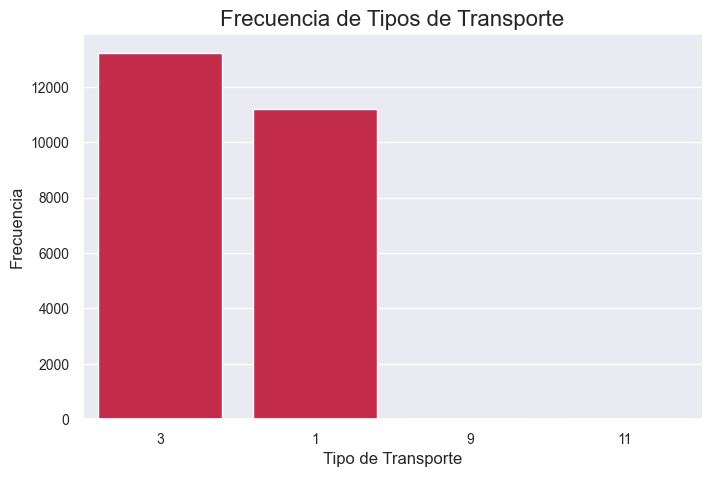

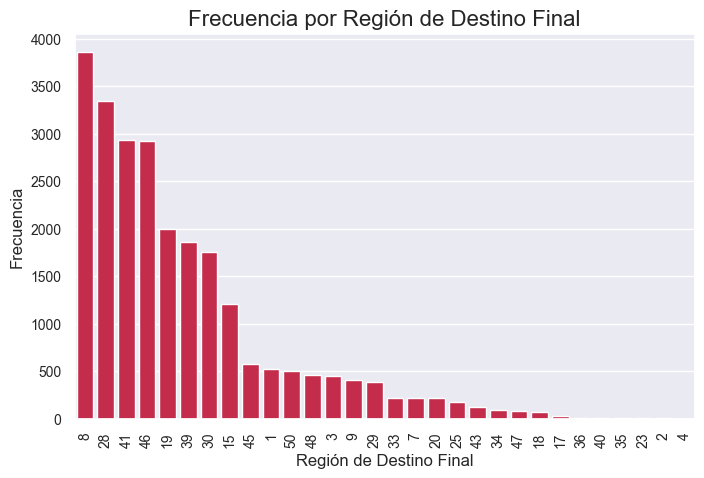

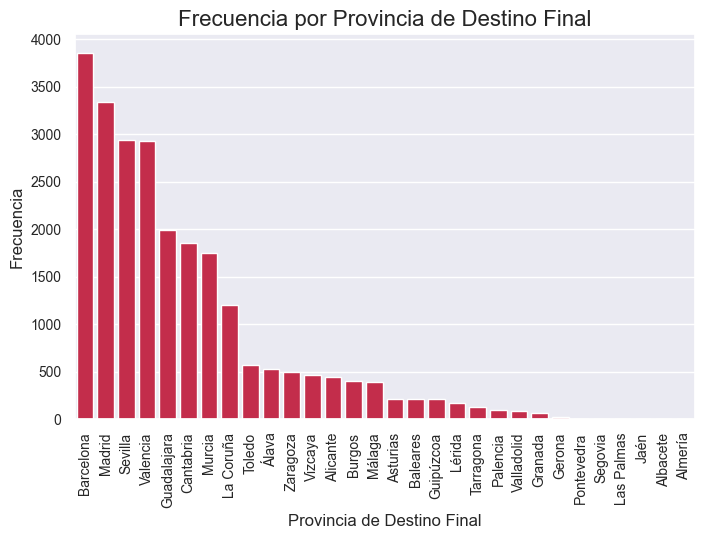

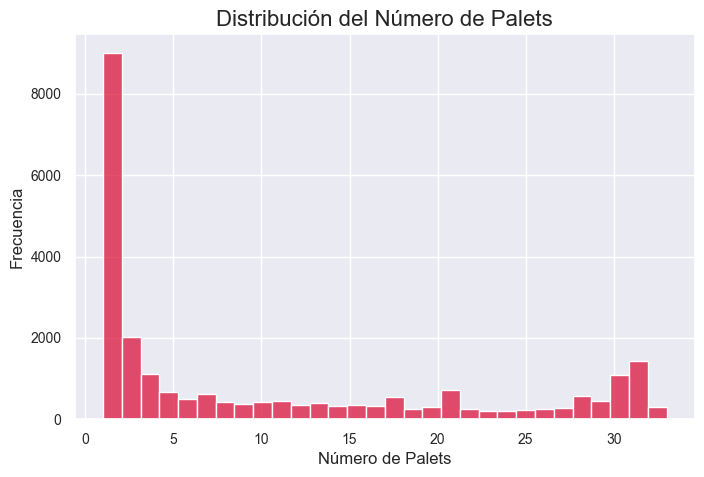

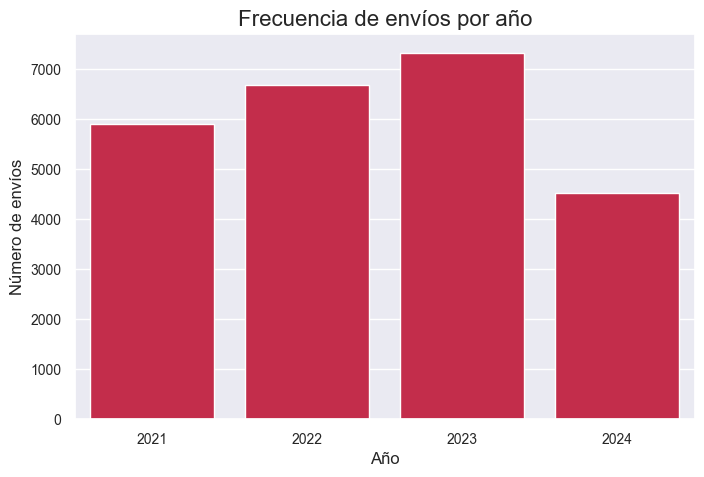

In [ ]:
df_historico['fecha_real_carga'] = pd.to_datetime(df_historico['fecha_real_carga'], errors='coerce')

# 1. Gráfico de barras para 'id_tipo_transporte'

plt.figure(figsize=(8, 5))
sns.countplot(x='id_tipo_transporte', data=df_historico,
              order=df_historico['id_tipo_transporte'].value_counts().index,
              color="crimson")
plt.title('Frecuencia de Tipos de Transporte', fontsize=16)
plt.xlabel('Tipo de Transporte', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 2. Gráfico de barras para 'region_destino_final'
plt.figure(figsize=(8, 5))
sns.countplot(x='region_destino_final', data=df_historico,
              order=df_historico['region_destino_final'].value_counts().index,
              color="crimson")
plt.title('Frecuencia por Región de Destino Final', fontsize=16)
plt.xlabel('Región de Destino Final', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.show()

# 3. Gráfico de barras para 'provincia_destino_final'
plt.figure(figsize=(8, 5))
sns.countplot(x='provincia_destino_final', data=df_historico,
              order=df_historico['provincia_destino_final'].value_counts().index,
              color="crimson")
plt.title('Frecuencia por Provincia de Destino Final', fontsize=16)
plt.xlabel('Provincia de Destino Final', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.show()

# 4. Histograma para 'numero_pales' (como barras verticales)
plt.figure(figsize=(8, 5))
sns.histplot(df_historico['numero_pales'], bins=30, kde=False, color="crimson")
plt.title('Distribución del Número de Palets', fontsize=16)
plt.xlabel('Número de Palets', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#5: Frecuencia de envíos por año
plt.figure(figsize=(8, 5))
df_historico['ano'] = df_historico['fecha_real_carga'].dt.year
sns.countplot(x='ano', data=df_historico,
              order=df_historico['ano'].value_counts().index.sort_values(),
              color="crimson")
plt.title('Frecuencia de envíos por año', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Número de envíos', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### Análisis de la variable 'fecha_real_carga'

In [ ]:
df_historico['fecha_real_carga'] = pd.to_datetime(df_historico['fecha_real_carga'])

Comprobamos la primera y ultima fecha del dataset

In [ ]:
primera_fecha = df_historico['fecha_real_carga'].min()
print(primera_fecha)

2021-01-01 00:13:37.697000


In [ ]:
ultima_fecha = df_historico['fecha_real_carga'].max()
print(ultima_fecha)

2024-07-29 19:28:00


Los datos abarcan desde **enero de 2021** hasta **julio de 2024**.

A continuación vamos a añadir varias variables al dataset relacionadas con la variable 'fecha_real_carga' para poder usarlas en la creación de gráficos:

In [ ]:
df_historico['ano'] = df_historico['fecha_real_carga'].dt.year
df_historico ['mes'] = df_historico['fecha_real_carga'].dt.month
df_historico['dia'] = df_historico['fecha_real_carga'].dt.day
df_historico['semana'] = df_historico['fecha_real_carga'].dt.isocalendar().week

Por último, añadimos al dataset la variable 'fecha' sin hora:

In [ ]:
df_historico['fecha'] = df_historico['fecha_real_carga'].dt.date

df_historico['fecha'] = pd.to_datetime(df_historico['fecha'])

In [ ]:
df_historico.head()

,id_orden,fecha_real_carga,id_tipo_transporte,incoterms,region_origen,provincia_origen,id_pais_origen,region_destino_final,provincia_destino_final,id_pais_destino,numero_pales,incidencia,ano,mes,dia,semana,fecha
0,OCZ0671450,2022-02-25 09:46:00,1,DAP,30,Murcia,ES,19,Guadalajara,ES,33,False,2022,2,25,8,2022-02-25
1,OCZ0691381,2022-06-20 08:58:00,1,DAP,30,Murcia,ES,7,Baleares,ES,33,False,2022,6,20,25,2022-06-20
2,OCZ0737222,2023-02-22 16:35:00,3,DAP,30,Murcia,ES,41,Sevilla,ES,33,False,2023,2,22,8,2023-02-22
3,OCZ0816341,2024-04-26 05:12:00,3,DAP,30,Murcia,ES,46,Valencia,ES,33,False,2024,4,26,17,2024-04-26
4,OCZ0818124,2024-05-30 08:22:00,3,DAP,30,Murcia,ES,28,Madrid,ES,33,False,2024,5,30,22,2024-05-30


### Análisis de la evolución del volumen total de pedidos a lo largo del tiempo

#### Análisis mensual

In [ ]:
# Se agrupan los datos por mes para analizar el volumen total de pedidos
volumen_mensual = df_historico.groupby(df_historico['fecha_real_carga'].dt.to_period('M')).agg({'numero_pales': 'sum'}).reset_index()

In [ ]:
# Se convierte la columna 'fecha_real_carga' a tipo datetime para graficar
volumen_mensual['fecha_real_carga'] = volumen_mensual['fecha_real_carga'].dt.to_timestamp()

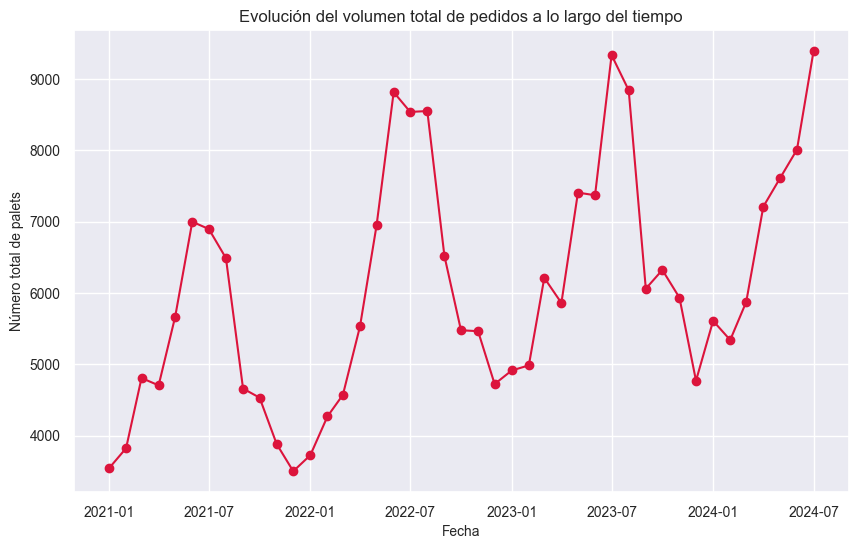

In [ ]:
# Visualización inicial del volumen total de pedidos a lo largo del tiempo
plt.figure(figsize=(10, 6))
plt.plot(volumen_mensual['fecha_real_carga'], volumen_mensual['numero_pales'], marker='o', linestyle='-',color="crimson")
plt.title('Evolución del volumen total de pedidos a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Número total de palets')
plt.grid(True)
plt.show()

Este gráfico representa el volumen total de pedidos (número de palets) a lo largo del tiempo. Este gráfico da una visión clara de las tendencias globales en cuanto a los volúmenes de carga.

Observaciones

- Se observan fluctuaciones significativas en el volumen total de carga en distintos momentos del tiempo.
  
- Hay picos claros en determinados meses (periodo estival) lo que podría sugerir patrones estacionales o eventos específicos que incrementan la demanda de carga.
  
- También se aprecian periodos de caída en la actividad (periodo invernal).

- Además se observa una tendencia al alza en el volumen de pedidos a lo largo de los años.

In [ ]:
# Número de palets enviados por mes
palets_por_mes = df_historico.groupby(['ano', 'mes'])['numero_pales'].sum().reset_index()

print(palets_por_mes)

     ano  mes  numero_pales
0   2021    1          3540
1   2021    2          3822
2   2021    3          4807
3   2021    4          4704
4   2021    5          5667
5   2021    6          6999
6   2021    7          6897
7   2021    8          6489
8   2021    9          4659
9   2021   10          4531
10  2021   11          3880
11  2021   12          3499
12  2022    1          3725
13  2022    2          4268
14  2022    3          4571
15  2022    4          5532
16  2022    5          6947
17  2022    6          8817
18  2022    7          8540
19  2022    8          8552
20  2022    9          6519
21  2022   10          5477
22  2022   11          5464
23  2022   12          4722
24  2023    1          4913
25  2023    2          4984
26  2023    3          6212
27  2023    4          5860
28  2023    5          7408
29  2023    6          7371
30  2023    7          9337
31  2023    8          8844
32  2023    9          6060
33  2023   10          6323
34  2023   11       

In [ ]:
# Se obtiene la media de los palets enviados en cada mes a lo largo de los años
palets_por_mes = df_historico.groupby(['ano', 'mes'])['numero_pales'].sum().reset_index()

media_palets_por_mes = palets_por_mes.groupby('mes')['numero_pales'].mean().reset_index().round(0)

print(media_palets_por_mes)

    mes  numero_pales
0     1        4447.0
1     2        4604.0
2     3        5366.0
3     4        5827.0
4     5        6907.0
5     6        7800.0
6     7        8541.0
7     8        7962.0
8     9        5746.0
9    10        5444.0
10   11        5093.0
11   12        4330.0


Dado que se trata de un problema de Series Temporales Multivariante, no se utilizará los modelos típicos de Series Temporales Univariantes (ARIMA, ARIMAX o AUTOARIMA), pero de igual manera se analizará a continuación la estacionariedad y estacionalidad de la serie en el tiempo.
En este caso se hará de forma mensual.

In [ ]:
# Se crea una función para identificar si existe estacionariedad

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression ='ct')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
#Se hace una copia del dataset ya que a continuación se pondrá como índice la fecha
df_copia = df_historico.copy()

In [ ]:
#Se convierte en una serie temporal poniendo como index la variable fecha_real_carga
df_copia.set_index(['fecha'],inplace=True)

In [ ]:
df_copia.head()

,id_orden,fecha_real_carga,id_tipo_transporte,incoterms,region_origen,provincia_origen,id_pais_origen,region_destino_final,provincia_destino_final,id_pais_destino,numero_pales,incidencia,ano,mes,dia,semana
fecha,,,,,,,,,,,,,,,,
2022-02-25,OCZ0671450,2022-02-25 09:46:00,1,DAP,30,Murcia,ES,19,Guadalajara,ES,33,False,2022,2,25,8
2022-06-20,OCZ0691381,2022-06-20 08:58:00,1,DAP,30,Murcia,ES,7,Baleares,ES,33,False,2022,6,20,25
2023-02-22,OCZ0737222,2023-02-22 16:35:00,3,DAP,30,Murcia,ES,41,Sevilla,ES,33,False,2023,2,22,8
2024-04-26,OCZ0816341,2024-04-26 05:12:00,3,DAP,30,Murcia,ES,46,Valencia,ES,33,False,2024,4,26,17
2024-05-30,OCZ0818124,2024-05-30 08:22:00,3,DAP,30,Murcia,ES,28,Madrid,ES,33,False,2024,5,30,22


In [ ]:
df_res_mensual = df_copia['numero_pales'].resample('ME').sum()

In [ ]:
df_res_mensual.head()

fecha
2021-01-31    3540
2021-02-28    3822
2021-03-31    4807
2021-04-30    4704
2021-05-31    5667
Freq: ME, Name: numero_pales, dtype: int64

In [ ]:
test_stationarity(df_res_mensual)

Results of Dickey-Fuller Test:
Test Statistic                 -4.581794
p-value                         0.001106
#Lags Used                      6.000000
Number of Observations Used    36.000000
Critical Value (1%)            -4.235056
Critical Value (5%)            -3.540390
Critical Value (10%)           -3.202380
dtype: float64


**Análisis de la estacionariedad**:

- El estadístico de prueba es bastante negativo (-4.581794) lo que generalmente sugiere una mayor probabilidad de que la serie sea estacionaria.

- Un p-valor de 0.001106 es muy bajo, lo que significa que hay una fuerte evidencia en contra de la hipótesis nula (serie no estacionaria). Esto implica que es muy poco probable que la serie temporal sea no estacionaria.

- Se han utilizado 6 lags, lo que significa que se consideraron hasta seis periodos anteriores para calcular el estadístico de prueba. Esto es adecuado para series mensuales, ya que puede capturar la estacionalidad o las correlaciones a largo plazo.

- El hecho de tener 36 observaciones significa que estás trabajando con 3 años de datos mensuales, lo que es un período razonable para identificar patrones y tendencias en series temporales.

- El estadístico de prueba (-4.581794) es menor que todos los valores críticos al 1%, 5% y 10%, lo que permite rechazar la hipótesis nula de no estacionariedad.

Con todo esto, gracias a los resultados de la prueba de Dickey-Fuller, se puede concluir que la serie temporal es estacionaria. Esto significa que sus propiedades estadísticas (media, varianza, etc.) no cambian con el tiempo, lo cual es favorable para análisis y modelos de series temporales.

#### Análisis Semanal

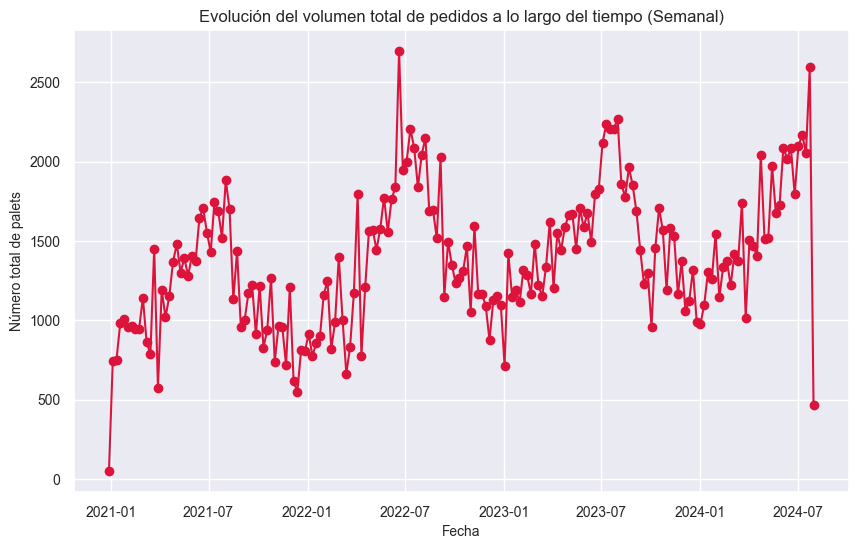

In [ ]:
# Se agrupan los datos por semana
volumen_semanal = df_historico.groupby(df_historico['fecha_real_carga'].dt.to_period('W')).agg({'numero_pales': 'sum'}).reset_index()

# Convertir de nuevo la columna 'fecha_real_carga' a tipo datetime para graficar
volumen_semanal['fecha_real_carga'] = volumen_semanal['fecha_real_carga'].dt.to_timestamp()

# Visualización del volumen total de pedidos a lo largo del tiempo por semana
plt.figure(figsize=(10, 6))
plt.plot(volumen_semanal['fecha_real_carga'], volumen_semanal['numero_pales'], marker='o', linestyle='-',color="crimson")
plt.title('Evolución del volumen total de pedidos a lo largo del tiempo (Semanal)')
plt.xlabel('Fecha')
plt.ylabel('Número total de palets')
plt.grid(True)
plt.show()

El gráfico semanal muestra más variabilidad, pero sigue siendo bastante claro. Las fluctuaciones son más notables, y se observan patrones cíclicos similares al gráfico mensual.

Este nivel de granularidad es útil para capturar comportamientos semanales o quincenales que pueden pasar desapercibidos en los datos mensuales.

In [ ]:
# Se obtiene la media de los palets enviados en cada semana a lo largo de los años
df_historico['fecha_real_carga'] = pd.to_datetime(df_historico['fecha_real_carga'])

df_historico['ano'] = df_historico['fecha_real_carga'].dt.year
df_historico['semana'] = df_historico['fecha_real_carga'].dt.isocalendar().week

palets_por_semana = df_historico.groupby(['ano', 'semana'])['numero_pales'].sum().reset_index()

media_palets_por_semana = palets_por_semana.groupby('semana')['numero_pales'].mean().reset_index().round(0)

print(media_palets_por_semana)

    semana  numero_pales
0        1         838.0
1        2        1014.0
2        3        1074.0
3        4        1089.0
4        5        1196.0
5        6        1170.0
6        7        1097.0
7        8        1120.0
8        9        1312.0
9       10        1126.0
10      11         995.0
11      12        1342.0
12      13        1096.0
13      14        1424.0
14      15        1204.0
15      16        1303.0
16      17        1641.0
17      18        1557.0
18      19        1485.0
19      20        1599.0
20      21        1610.0
21      22        1570.0
22      23        1727.0
23      24        1749.0
24      25        2070.0
25      26        1780.0
26      27        1913.0
27      28        2090.0
28      29        2010.0
29      30        2040.0
30      31        1667.0
31      32        1905.0
32      33        1533.0
33      34        1698.0
34      35        1443.0
35      36        1573.0
36      37        1255.0
37      38        1316.0
38      39        1188.0


 En este caso se estudia la estacionariedad de forma semanal:

In [ ]:
df_res_semanal = df_copia['numero_pales'].resample('W').sum()

In [ ]:
df_res_semanal

fecha
2021-01-03      50
2021-01-10     744
2021-01-17     754
2021-01-24     985
2021-01-31    1007
              ... 
2024-07-07    2101
2024-07-14    2167
2024-07-21    2058
2024-07-28    2595
2024-08-04     470
Freq: W-SUN, Name: numero_pales, Length: 188, dtype: int64

In [ ]:
test_stationarity(df_res_semanal)

Results of Dickey-Fuller Test:
Test Statistic                  -3.002722
p-value                          0.131322
#Lags Used                       2.000000
Number of Observations Used    185.000000
Critical Value (1%)             -4.008557
Critical Value (5%)             -3.434493
Critical Value (10%)            -3.141144
dtype: float64


**Análisis de la estacionariedad**:

- El estadístico de prueba -3.002722 es mayor que todos los valores críticos (es decir, no es más negativa), por lo que no se puede rechazar la hipótesis nula a ninguno de los niveles de significancia tradicionales (1%, 5%, 10%).

- Con un p-valor de 0.131322, que es mayor que el nivel común de significancia de 0.05, también respalda la conclusión de que no se puede rechazar la hipótesis nula de no estacionariedad.

Conclusión: la serie probablemente **no es estacionaria**, ya que ni el valor p ni la estadística del test sugieren que puedas rechazar la hipótesis nula de no estacionariedad.

#### Análisis Diario

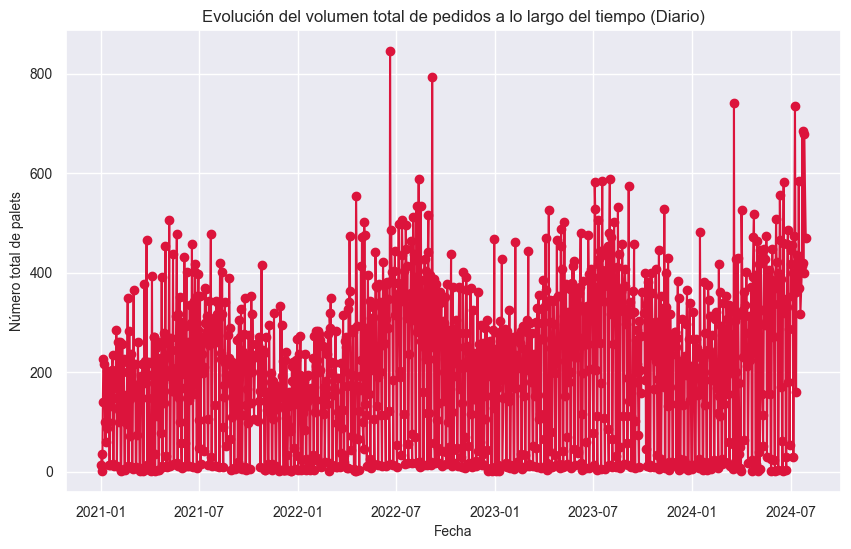

In [ ]:
# Se agrupan los datos por día
volumen_diario = df_historico.groupby(df_historico['fecha_real_carga'].dt.to_period('D')).agg({'numero_pales': 'sum'}).reset_index()

volumen_diario['fecha_real_carga'] = volumen_diario['fecha_real_carga'].dt.to_timestamp()

# Visualización del volumen total de pedidos a lo largo del tiempo por día
plt.figure(figsize=(10, 6))
plt.plot(volumen_diario['fecha_real_carga'], volumen_diario['numero_pales'], marker='o', linestyle='-',color="crimson")
plt.title('Evolución del volumen total de pedidos a lo largo del tiempo (Diario)')
plt.xlabel('Fecha')
plt.ylabel('Número total de palets')
plt.grid(True)
plt.show()

El gráfico diario muestra una gran variabilidad y ruido. Esto es normal para los datos diarios, ya que puede haber fluctuaciones más pronunciadas en función de eventos específicos.

La predicción a nivel diario podría ser más complicada debido a este alto nivel de variabilidad.

### Análisis de la evolución del volumen total de pedidos por tipo de transporte

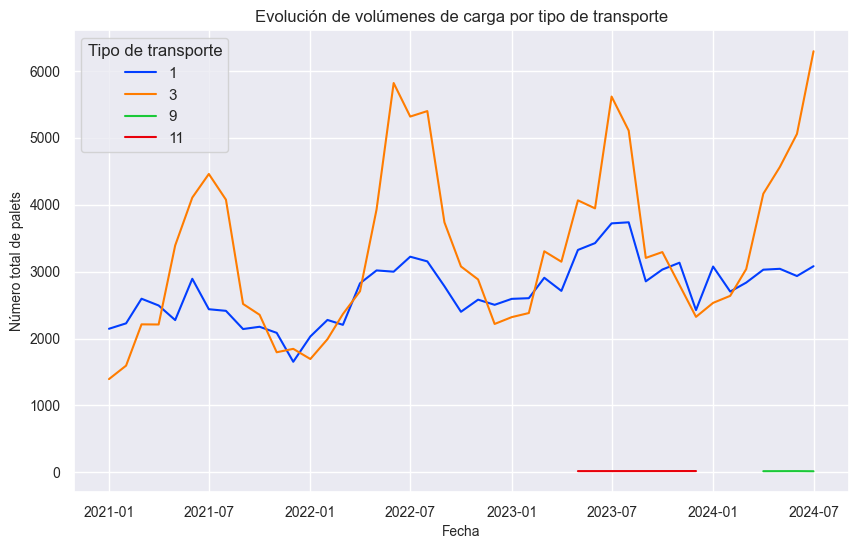

In [ ]:
# Se agrupa por fecha y tipo de transporte para ver la evolución de los volúmenes de carga
volumen_carga = df_historico.groupby([df_historico['fecha_real_carga'].dt.to_period('M'), 'id_tipo_transporte']).agg({'numero_pales': 'sum'}).reset_index()

volumen_carga['fecha_real_carga'] = volumen_carga['fecha_real_carga'].dt.to_timestamp()

# Visualización inicial de la evolución de volúmenes de carga por tipo de transporte
plt.figure(figsize=(10, 6))
sns.lineplot(x='fecha_real_carga', y='numero_pales', hue='id_tipo_transporte', data=volumen_carga, palette='bright')
plt.title('Evolución de volúmenes de carga por tipo de transporte')
plt.xlabel('Fecha')
plt.ylabel('Número total de palets')
plt.legend(title='Tipo de transporte')
plt.show()

Esta es una visualización de la **evolución de los volumenes de carga** (nº de pallets) desglosada por tipo de transporte a lo largo del tiempo.

**Observaciones:**

- Existe una clara variabilidad en los volúmenes de carga a lo largo del tiempo, con algunos periodos donde se registran picos significativos de actividad. Algunos tipos de transporte presentan picos más pronunciados en ciertos meses, lo que sugiere la existencia de patrones estacionales o picos de demanda en periodos específicos:
  
- Camión Frigo (id_tipo_transporte 3) parece ser uno de los tipos de transporte que consistentemente maneja un gran volumen de palets, lo cual podría indicar que es el medio de transporte preferido o más eficiente en muchas rutas.
  
- Camión Lona (id_tipo_transporte 1) también tiene una tendencia estable y se ve utilizado durante todo el periodo, aunque con menor volumen que el camión Frigo.
  
- Otros tipos de transporte, como los contenedores refrigerados (id_tipo_transporte 9 y 11), muestran menos actividad, pero pueden estar asociados a nichos o rutas específicas donde es necesario el control de temperatura.

- Se observan algunos picos de carga notables en periodos concretos (posiblemente en los meses de mayor demanda estacional), seguidos de caídas significativas: Camión lona y camión frigo presentan los mayores volúmenes de carga. El **camión frigo muestra un pico importante en julio de 2024**, y el **camión lona en agosto de 2023**. Los otros tipos de transporte, como los contenedores DRY VAN, tienen un volumen de carga muy bajo en general, lo que puede indicar que son usados para cargas más específicas o menos frecuentes. **Los mínimos de los volúmenes de carga** tienden a estar en periodos invernales para camión lona y frigo, lo que podría sugerir una menor demanda en esas épocas.

- En algunos tipos de transporte, como los camiones lona y frigo (id_tipo_transporte 1 y 3), parece haber una **tendencia creciente** en el volumen de palets a medida que avanza el tiempo. Esto sugiere que el uso de este transporte puede estar aumentando debido a la demanda o la eficiencia percibida de este medio.

### Análisis de correlación

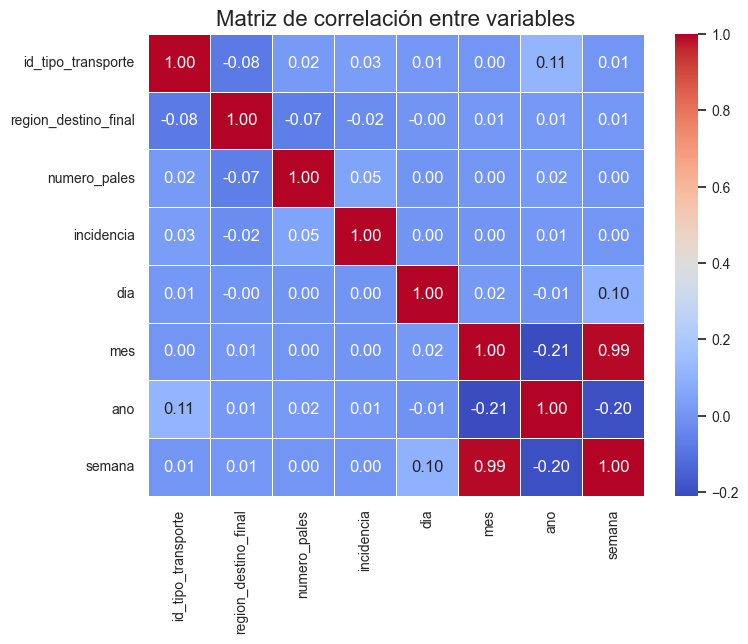

In [ ]:
df_corr = df_historico.copy()

df_corr['id_tipo_transporte'] = df_corr['id_tipo_transporte'].astype(int)
df_corr['incidencia'] = df_corr['incidencia'].astype(int)

corr_variables = ['id_tipo_transporte', 'region_destino_final', 'numero_pales', 'incidencia', 'dia','mes','ano','semana']

corr_matrix = df_corr[corr_variables].corr()

# Mapa de calor de la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de correlación entre variables', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Observaciones:

- Correlación Baja en General: La mayoría de las variables presentan correlaciones muy bajas entre sí y con la variable objetivo (numero_pales), lo que sugiere que no hay relaciones lineales fuertes entre las variables seleccionadas.

- La única correlación ligeramente notable es entre id_tipo_transporte y año (0.11). Esto podría indicar que ciertos tipos de transporte han sido utilizados con mayor frecuencia en determinados años, pero la correlación sigue siendo baja.

- Las variables temporales (año, mes, dia, semana) no parecen estar correlacionadas significativamente con numero_pales. Esto podría indicar que, en promedio, no hay una relación directa entre el volumen de palets enviados y el día, mes o año. Sin embargo, puede que existen patrones no lineales o estacionales que esta matriz de correlación lineal no está capturando.

- La baja correlación entre las variables sugiere que los modelos basados únicamente en relaciones lineales, como la regresión lineal, podrían no ser muy efectivos para este conjunto de datos. Es probable que sea necesario utilizar modelos más complejos (como Random Forest o XGBoost), que puedan capturar relaciones no lineales o interacciones entre múltiples variables.

## 2. Feature Engineering

El objetivo de este proyecto es predecir el volumen de cargas por zona de destino y tipo de transporte.

Por ello, en este apartado se crearán diferentes variables que nos permitan identificar patrones en los envíos de pales a lo largo del tiempo, y se eliminarán aquellas variables que no contribuyan a la variabilidad de los datos.

En un paso previo, se crearon las siguientes variables relacionadas con 'fecha_real_carga':

In [ ]:
df_historico['ano'] = df_historico['fecha_real_carga'].dt.year
df_historico ['mes'] = df_historico['fecha_real_carga'].dt.month
df_historico['dia'] = df_historico['fecha_real_carga'].dt.day
df_historico['semana'] = df_historico['fecha_real_carga'].dt.isocalendar().week

df_historico['fecha'] = df_historico['fecha_real_carga'].dt.date
df_historico['fecha'] = pd.to_datetime(df_historico['fecha'])

A continuación, se transforma el tipo de dato de las variables del dataset:

In [ ]:
#Modificación de tipo object a string
df_historico = df_historico.astype({col: 'string' for col in df_historico.select_dtypes(include='object').columns})

In [ ]:
df_historico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24435 entries, 0 to 24434
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id_orden                 24435 non-null  string        
 1   fecha_real_carga         24435 non-null  datetime64[ns]
 2   id_tipo_transporte       24435 non-null  int64         
 3   incoterms                24435 non-null  string        
 4   region_origen            24435 non-null  int64         
 5   provincia_origen         24435 non-null  string        
 6   id_pais_origen           24435 non-null  string        
 7   region_destino_final     24435 non-null  int64         
 8   provincia_destino_final  24435 non-null  string        
 9   id_pais_destino          24435 non-null  string        
 10  numero_pales             24435 non-null  int64         
 11  incidencia               24435 non-null  bool          
 12  ano                      24435 n

Se crea una variable que concatene el tipo de transporte y la región de destino final. De esta forma tendremos las distintas combinaciones transporte-destino y se podrá analizar si existe una correlación entre esta y el número de pales enviados.

Esta nueva variable se llamará **transporte_destino** y luego de combinarla, la transformaremos con un label encoder para usarla dentro de nuestro modelo más adelante.

In [ ]:
df_historico['transporte_destino'] = df_historico['id_tipo_transporte'].astype(str) + '_' + df_historico['region_destino_final'].astype(str)

In [ ]:
df_historico.head()

,id_orden,fecha_real_carga,id_tipo_transporte,incoterms,region_origen,provincia_origen,id_pais_origen,region_destino_final,provincia_destino_final,id_pais_destino,numero_pales,incidencia,ano,mes,dia,semana,fecha,transporte_destino
0,OCZ0671450,2022-02-25 09:46:00,1,DAP,30,Murcia,ES,19,Guadalajara,ES,33,False,2022,2,25,8,2022-02-25,1_19
1,OCZ0691381,2022-06-20 08:58:00,1,DAP,30,Murcia,ES,7,Baleares,ES,33,False,2022,6,20,25,2022-06-20,1_7
2,OCZ0737222,2023-02-22 16:35:00,3,DAP,30,Murcia,ES,41,Sevilla,ES,33,False,2023,2,22,8,2023-02-22,3_41
3,OCZ0816341,2024-04-26 05:12:00,3,DAP,30,Murcia,ES,46,Valencia,ES,33,False,2024,4,26,17,2024-04-26,3_46
4,OCZ0818124,2024-05-30 08:22:00,3,DAP,30,Murcia,ES,28,Madrid,ES,33,False,2024,5,30,22,2024-05-30,3_28


In [ ]:
# Se calcula el número de combinaciones únicas

df_historico['transporte_destino'].nunique()

51

In [ ]:
le = LabelEncoder()

# Se aplica Label Encoding
df_historico['label'] = le.fit_transform(df_historico['transporte_destino'])

In [ ]:
df_historico['transporte_destino'] = df_historico['label']

df_historico.drop(columns=['label'], inplace=True)

In [ ]:
df_historico

,id_orden,fecha_real_carga,id_tipo_transporte,incoterms,region_origen,provincia_origen,id_pais_origen,region_destino_final,provincia_destino_final,id_pais_destino,numero_pales,incidencia,ano,mes,dia,semana,fecha,transporte_destino
0,OCZ0671450,2022-02-25 09:46:00.000,1,DAP,30,Murcia,ES,19,Guadalajara,ES,33,False,2022,2,25,8,2022-02-25,5
1,OCZ0691381,2022-06-20 08:58:00.000,1,DAP,30,Murcia,ES,7,Baleares,ES,33,False,2022,6,20,25,2022-06-20,23
2,OCZ0737222,2023-02-22 16:35:00.000,3,DAP,30,Murcia,ES,41,Sevilla,ES,33,False,2023,2,22,8,2023-02-22,41
3,OCZ0816341,2024-04-26 05:12:00.000,3,DAP,30,Murcia,ES,46,Valencia,ES,33,False,2024,4,26,17,2024-04-26,44
4,OCZ0818124,2024-05-30 08:22:00.000,3,DAP,30,Murcia,ES,28,Madrid,ES,33,False,2024,5,30,22,2024-05-30,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24430,OCZ0703007,2022-08-08 07:56:19.223,1,DAP,30,Murcia,ES,41,Sevilla,ES,1,False,2022,8,8,32,2022-08-08,17
24431,OCZ0738274,2023-02-28 15:45:00.000,3,DAP,30,Murcia,ES,28,Madrid,ES,1,False,2023,2,28,9,2023-02-28,33
24432,OCZ0787730,2023-11-08 12:33:00.000,3,DAP,30,Murcia,ES,28,Madrid,ES,1,False,2023,11,8,45,2023-11-08,33
24433,OCZ0787728,2023-11-06 15:49:00.000,3,DAP,30,Murcia,ES,46,Valencia,ES,1,False,2023,11,6,45,2023-11-06,44


In [ ]:
df_historico['transporte_destino'].nunique()

51

Hay un total de 51 combinaciones únicas transporte-destino en el dataset. Esto quiere decir que hay destinos a los que solamente se envían pales mediante un tipo de trasporte y otros en los que se utilizan más de un tipo de transporte.

A continuación, se hace una **copia del dataframe df_historico** que se llamará df_final, para poder utilizar df_historico más adelante tras la aplicación del modelo. La copia de este dataframe será en la que se modificarán y eliminarán las variables pertinentes.

In [ ]:
df_final = df_historico.copy()

In [ ]:
#En primer lugar, se eliminan las variables que no servirán para el modelo

df_final.drop(['provincia_origen'],axis= 1,inplace=True)
df_final.drop(['provincia_destino_final'],axis= 1,inplace=True) #se elimna ya que representa lo mismo que 'region_destino_final'
df_final.drop(['fecha_real_carga'],axis= 1,inplace=True) #se elimina ya que se tiene la 'fecha' sin hora
df_final.drop(['id_pais_origen'],axis= 1,inplace=True)
df_final.drop(['id_pais_destino'],axis= 1,inplace=True)
df_final.drop(['incoterms'],axis= 1,inplace=True)
df_final.drop(['region_origen'],axis= 1,inplace=True)
df_final.drop(['incidencia'],axis= 1,inplace=True)  #se elimina ya que tiene muy baja correlación con el resto de variables

In [ ]:
df_final.head()

,id_orden,id_tipo_transporte,region_destino_final,numero_pales,ano,mes,dia,semana,fecha,transporte_destino
0,OCZ0671450,1,19,33,2022,2,25,8,2022-02-25,5
1,OCZ0691381,1,7,33,2022,6,20,25,2022-06-20,23
2,OCZ0737222,3,41,33,2023,2,22,8,2023-02-22,41
3,OCZ0816341,3,46,33,2024,4,26,17,2024-04-26,44
4,OCZ0818124,3,28,33,2024,5,30,22,2024-05-30,33


In [ ]:
palets_por_mes = df_final.groupby(['ano', 'mes'])['numero_pales'].sum().reset_index()

media_palets_por_mes = palets_por_mes.groupby('mes')['numero_pales'].mean().reset_index().round(0)
media_palets_por_mes = media_palets_por_mes.rename(columns={'numero_pales': 'promedio_numero_pales_mensual'})

In [ ]:
media_palets_por_mes

,mes,promedio_numero_pales_mensual
0,1,4447.0
1,2,4604.0
2,3,5366.0
3,4,5827.0
4,5,6907.0
5,6,7800.0
6,7,8541.0
7,8,7962.0
8,9,5746.0
9,10,5444.0


In [ ]:
df_final = df_final.merge(media_palets_por_mes, on='mes', how='left')

In [ ]:
palets_por_semana = df_final.groupby(['ano', 'semana'])['numero_pales'].sum().reset_index()

media_palets_por_semana = palets_por_semana.groupby('semana')['numero_pales'].mean().reset_index().round(0)
media_palets_por_semana = media_palets_por_semana.rename(columns={'numero_pales': 'promedio_numero_pales_semanal'})

In [ ]:
media_palets_por_semana

,semana,promedio_numero_pales_semanal
0,1,838.0
1,2,1014.0
2,3,1074.0
3,4,1089.0
4,5,1196.0
5,6,1170.0
6,7,1097.0
7,8,1120.0
8,9,1312.0
9,10,1126.0


In [ ]:
df_final = df_final.merge(media_palets_por_semana, on='semana', how='left')

In [ ]:
df_final

,id_orden,id_tipo_transporte,region_destino_final,numero_pales,ano,mes,dia,semana,fecha,transporte_destino,promedio_numero_pales_mensual,promedio_numero_pales_semanal
0,OCZ0671450,1,19,33,2022,2,25,8,2022-02-25,5,4604.0,1120.0
1,OCZ0691381,1,7,33,2022,6,20,25,2022-06-20,23,7800.0,2070.0
2,OCZ0737222,3,41,33,2023,2,22,8,2023-02-22,41,4604.0,1120.0
3,OCZ0816341,3,46,33,2024,4,26,17,2024-04-26,44,5827.0,1641.0
4,OCZ0818124,3,28,33,2024,5,30,22,2024-05-30,33,6907.0,1570.0
...,...,...,...,...,...,...,...,...,...,...,...,...
24430,OCZ0703007,1,41,1,2022,8,8,32,2022-08-08,17,7962.0,1905.0
24431,OCZ0738274,3,28,1,2023,2,28,9,2023-02-28,33,4604.0,1312.0
24432,OCZ0787730,3,28,1,2023,11,8,45,2023-11-08,33,5093.0,1381.0
24433,OCZ0787728,3,46,1,2023,11,6,45,2023-11-06,44,5093.0,1381.0


In [ ]:
#Se transforman algunas variables segun su frecuencia
frecuencia_columns = ['id_tipo_transporte','region_destino_final']

for col in frecuencia_columns:
    freq_encoding = df_final[col].value_counts() / len(df_final)
    df_final[col + '_freq'] = df_final[col].map(freq_encoding)


df_final = df_final.drop(columns=frecuencia_columns)

In [ ]:
df_final.head()

,id_orden,numero_pales,ano,mes,dia,semana,fecha,transporte_destino,promedio_numero_pales_mensual,promedio_numero_pales_semanal,id_tipo_transporte_freq,region_destino_final_freq
0,OCZ0671450,33,2022,2,25,8,2022-02-25,5,4604.0,1120.0,0.457827,0.081768
1,OCZ0691381,33,2022,6,20,25,2022-06-20,23,7800.0,2070.0,0.457827,0.008922
2,OCZ0737222,33,2023,2,22,8,2023-02-22,41,4604.0,1120.0,0.541968,0.120156
3,OCZ0816341,33,2024,4,26,17,2024-04-26,44,5827.0,1641.0,0.541968,0.119705
4,OCZ0818124,33,2024,5,30,22,2024-05-30,33,6907.0,1570.0,0.541968,0.136853


In [ ]:
df_final.shape

(24435, 12)

A continuación, se agrupan los envíos por fecha, tipo de transporte, combinación transporte-destino,etc. y, para cada combinación única de estas columnas, se calcula:

- El total de pales (sumando los valores de la columna numero_pales).

- El número de envíos (contando las entradas de la columna id_orden).

In [ ]:
df_final = df_final.groupby(
    ['fecha', 'region_destino_final_freq', 'id_tipo_transporte_freq', 'transporte_destino', 'ano', 'mes', 'dia', 'semana','promedio_numero_pales_mensual','promedio_numero_pales_semanal']
).agg(
    numero_pales=('numero_pales', 'sum'),
    envios=('id_orden', 'count')
).reset_index()

In [ ]:
df_final.head()

,fecha,region_destino_final_freq,id_tipo_transporte_freq,transporte_destino,ano,mes,dia,semana,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales,envios
0,2021-01-01,0.075998,0.457827,14,2021,1,1,53,4447.0,50.0,3,1
1,2021-01-01,0.081768,0.457827,5,2021,1,1,53,4447.0,50.0,4,1
2,2021-01-01,0.119705,0.457827,20,2021,1,1,53,4447.0,50.0,1,1
3,2021-01-01,0.120156,0.457827,17,2021,1,1,53,4447.0,50.0,3,1
4,2021-01-01,0.157929,0.457827,24,2021,1,1,53,4447.0,50.0,2,1


Se agrupa el dataframe df_final por la variable 'transporte_destino' y se calcula el promedio de la columna 'envios' para cada combinación transporte-destino:

In [ ]:
promedio_envios_diario_transporte_destino = df_final.groupby('transporte_destino')['envios'].mean().reset_index()
promedio_envios_diario_transporte_destino.columns = ['transporte_destino', 'promedio_envios_diario_transporte_destino']

In [ ]:
promedio_envios_diario_transporte_destino

,transporte_destino,promedio_envios_diario_transporte_destino
0,0,1.000000
1,1,1.000000
2,2,1.480652
3,3,1.000000
4,4,1.000000
5,5,1.787190
6,6,1.000000
7,7,1.000000
8,8,1.000000
9,9,1.288168


Se hace un join para unir esta nueva variable 'promedio_envios_por_transporte_destino' al dataframe 'df_final':

In [ ]:
df_final = df_final.merge(promedio_envios_diario_transporte_destino, on='transporte_destino', how='left')

In [ ]:
df_final.head()

,fecha,region_destino_final_freq,id_tipo_transporte_freq,transporte_destino,ano,mes,dia,semana,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales,envios,promedio_envios_diario_transporte_destino
0,2021-01-01,0.075998,0.457827,14,2021,1,1,53,4447.0,50.0,3,1,1.808843
1,2021-01-01,0.081768,0.457827,5,2021,1,1,53,4447.0,50.0,4,1,1.787190
2,2021-01-01,0.119705,0.457827,20,2021,1,1,53,4447.0,50.0,1,1,1.617391
3,2021-01-01,0.120156,0.457827,17,2021,1,1,53,4447.0,50.0,3,1,1.494324
4,2021-01-01,0.157929,0.457827,24,2021,1,1,53,4447.0,50.0,2,1,1.875269


In [ ]:
df_final.shape

(15095, 13)

## 3. Creación de dataframes auxiliares

#### 3.1 Creación de dataframe de provincias

Este dataframe se utilizará para unirlo con la predicción final del modelo.

In [ ]:
df_provincias = df_historico[['id_tipo_transporte', 'region_destino_final', 'provincia_destino_final','transporte_destino']].drop_duplicates()

In [ ]:
df_provincias.head()

,id_tipo_transporte,region_destino_final,provincia_destino_final,transporte_destino
0,1,19,Guadalajara,5
1,1,7,Baleares,23
2,3,41,Sevilla,41
3,3,46,Valencia,44
4,3,28,Madrid,33


In [ ]:
df_unicos = df_final[['region_destino_final_freq', 'id_tipo_transporte_freq', 'transporte_destino']].drop_duplicates()

In [ ]:
df_unicos

,region_destino_final_freq,id_tipo_transporte_freq,transporte_destino
0,0.075998,0.457827,14
1,0.081768,0.457827,5
2,0.119705,0.457827,20
3,0.120156,0.457827,17
4,0.157929,0.457827,24
5,0.016534,0.541968,49
6,0.021608,0.541968,26
7,0.049355,0.541968,27
8,0.120156,0.541968,41
9,0.136853,0.541968,33


In [ ]:
df_provincias = pd.merge(df_provincias, df_unicos, on='transporte_destino', how='left')

In [ ]:
df_provincias.head()

,id_tipo_transporte,region_destino_final,provincia_destino_final,transporte_destino,region_destino_final_freq,id_tipo_transporte_freq
0,1,19,Guadalajara,5,0.081768,0.457827
1,1,7,Baleares,23,0.008922,0.457827
2,3,41,Sevilla,41,0.120156,0.541968
3,3,46,Valencia,44,0.119705,0.541968
4,3,28,Madrid,33,0.136853,0.541968


#### 3.2 Creación de dataframe diario para prediccion del 2024-2025

In [ ]:
from datetime import datetime, timedelta

In [ ]:
# Obtener el último día con datos reales
ultima_fecha_historico = df_historico['fecha'].max() + timedelta(days=1)

In [ ]:
ultima_fecha_historico

Timestamp('2024-07-30 00:00:00')

In [ ]:
ultima_fecha_prediccion = ultima_fecha_historico + timedelta(days= 365)

In [ ]:
ultima_fecha_prediccion

Timestamp('2025-07-30 00:00:00')

**NOTA**: Si se desea hacer una predicción desde la última fecha incluida en el histórico a un año vista, se tendría que modificar en la celda de codigo siguiente la fecha incluida en "end" por la variable **'ultima_fecha_prediccion'**.

Sin embargo, en este caso **se quiere predecir hasta finales de 2025** por lo que se introducirá la fecha **'2025-12-31'** manualmente:

In [ ]:
fechas_pred = pd.date_range(start=ultima_fecha_historico, end='2025-12-31', freq='D')

In [ ]:
fechas_pred

DatetimeIndex(['2024-07-30', '2024-07-31', '2024-08-01', '2024-08-02',
               '2024-08-03', '2024-08-04', '2024-08-05', '2024-08-06',
               '2024-08-07', '2024-08-08',
               ...
               '2025-12-22', '2025-12-23', '2025-12-24', '2025-12-25',
               '2025-12-26', '2025-12-27', '2025-12-28', '2025-12-29',
               '2025-12-30', '2025-12-31'],
              dtype='datetime64[ns]', length=520, freq='D')

A continuación, con el objetivo de crear el dataframe que se usará en la predicción, se lleva a cabo lo siguiente:

1. Se crea un dataframe con todas las combinaciones únicas de todas las variables excepto la variable objetivo (numero_pales).
2. Este dataframe se multiplica por el dataframe 'fechas_pred' que contiene el periodo que se quiere predecir.

In [ ]:
combinaciones_dia = df_final[['transporte_destino', 'region_destino_final_freq', 'id_tipo_transporte_freq']].drop_duplicates()

In [ ]:
combinaciones_dia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 0 to 13818
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transporte_destino         51 non-null     int32  
 1   region_destino_final_freq  51 non-null     float64
 2   id_tipo_transporte_freq    51 non-null     float64
dtypes: float64(2), int32(1)
memory usage: 1.4 KB


In [ ]:
df_final

,fecha,region_destino_final_freq,id_tipo_transporte_freq,transporte_destino,ano,mes,dia,semana,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales,envios,promedio_envios_diario_transporte_destino
0,2021-01-01,0.075998,0.457827,14,2021,1,1,53,4447.0,50.0,3,1,1.808843
1,2021-01-01,0.081768,0.457827,5,2021,1,1,53,4447.0,50.0,4,1,1.787190
2,2021-01-01,0.119705,0.457827,20,2021,1,1,53,4447.0,50.0,1,1,1.617391
3,2021-01-01,0.120156,0.457827,17,2021,1,1,53,4447.0,50.0,3,1,1.494324
4,2021-01-01,0.157929,0.457827,24,2021,1,1,53,4447.0,50.0,2,1,1.875269
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15090,2024-07-29,0.075998,0.541968,40,2024,7,29,31,8541.0,1667.0,3,1,1.283747
15091,2024-07-29,0.119705,0.541968,44,2024,7,29,31,8541.0,1667.0,104,6,1.871094
15092,2024-07-29,0.120156,0.541968,41,2024,7,29,31,8541.0,1667.0,10,2,1.955322
15093,2024-07-29,0.136853,0.541968,33,2024,7,29,31,8541.0,1667.0,28,5,2.771547


In [ ]:
df_prediccion_dia = pd.merge(
    pd.DataFrame({'fecha': fechas_pred}),
    combinaciones_dia,
    how='cross'
)

In [ ]:
df_prediccion_dia.shape

(26520, 4)

In [ ]:
df_prediccion_dia.head()

,fecha,transporte_destino,region_destino_final_freq,id_tipo_transporte_freq
0,2024-07-30,14,0.075998,0.457827
1,2024-07-30,5,0.081768,0.457827
2,2024-07-30,20,0.119705,0.457827
3,2024-07-30,17,0.120156,0.457827
4,2024-07-30,24,0.157929,0.457827


Se agregan al dataframe de predicción las variables año, mes, dia y semana:

In [ ]:
df_prediccion_dia['ano'] = df_prediccion_dia['fecha'].dt.year
df_prediccion_dia['mes'] = df_prediccion_dia['fecha'].dt.month
df_prediccion_dia['dia'] = df_prediccion_dia['fecha'].dt.day
df_prediccion_dia['semana'] = df_prediccion_dia['fecha'].dt.isocalendar().week

In [ ]:
df_prediccion_dia.head()

,fecha,transporte_destino,region_destino_final_freq,id_tipo_transporte_freq,ano,mes,dia,semana
0,2024-07-30,14,0.075998,0.457827,2024,7,30,31
1,2024-07-30,5,0.081768,0.457827,2024,7,30,31
2,2024-07-30,20,0.119705,0.457827,2024,7,30,31
3,2024-07-30,17,0.120156,0.457827,2024,7,30,31
4,2024-07-30,24,0.157929,0.457827,2024,7,30,31


In [ ]:
df_prediccion_dia = df_prediccion_dia.merge(promedio_envios_diario_transporte_destino, on='transporte_destino', how='left')

In [ ]:
df_prediccion_dia = df_prediccion_dia.merge(media_palets_por_semana, on='semana', how='left')

In [ ]:
df_prediccion_dia = df_prediccion_dia.merge(media_palets_por_mes, on='mes', how='left')

In [ ]:
df_prediccion_dia.sort_values(by='fecha')

,fecha,transporte_destino,region_destino_final_freq,id_tipo_transporte_freq,ano,mes,dia,semana,promedio_envios_diario_transporte_destino,promedio_numero_pales_semanal,promedio_numero_pales_mensual
0,2024-07-30,14,0.075998,0.457827,2024,7,30,31,1.808843,1667.0,8541.0
28,2024-07-30,46,0.018907,0.541968,2024,7,30,31,1.000000,1667.0,8541.0
29,2024-07-30,15,0.000041,0.457827,2024,7,30,31,1.000000,1667.0,8541.0
30,2024-07-30,28,0.001064,0.541968,2024,7,30,31,1.000000,1667.0,8541.0
31,2024-07-30,4,0.002947,0.457827,2024,7,30,31,1.000000,1667.0,8541.0
...,...,...,...,...,...,...,...,...,...,...,...
26489,2025-12-31,35,0.018171,0.541968,2025,12,31,1,1.190789,838.0,4330.0
26490,2025-12-31,21,0.018907,0.457827,2025,12,31,1,1.106796,838.0,4330.0
26491,2025-12-31,16,0.000286,0.457827,2025,12,31,1,1.000000,838.0,4330.0
26493,2025-12-31,22,0.020544,0.457827,2025,12,31,1,1.026087,838.0,4330.0


#### 3.2 Creación de dataframe semanal para prediccion del 2024-2025

In [ ]:
df_prediccion_dia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26520 entries, 0 to 26519
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   fecha                                      26520 non-null  datetime64[ns]
 1   transporte_destino                         26520 non-null  int32         
 2   region_destino_final_freq                  26520 non-null  float64       
 3   id_tipo_transporte_freq                    26520 non-null  float64       
 4   ano                                        26520 non-null  int32         
 5   mes                                        26520 non-null  int32         
 6   dia                                        26520 non-null  int32         
 7   semana                                     26520 non-null  UInt32        
 8   promedio_envios_diario_transporte_destino  26520 non-null  float64       
 9   promedio_numero_p

In [ ]:
df_pred_semanal = df_prediccion_dia.copy()

In [ ]:
df_pred_semanal

,fecha,transporte_destino,region_destino_final_freq,id_tipo_transporte_freq,ano,mes,dia,semana,promedio_envios_diario_transporte_destino,promedio_numero_pales_semanal,promedio_numero_pales_mensual
0,2024-07-30,14,0.075998,0.457827,2024,7,30,31,1.808843,1667.0,8541.0
1,2024-07-30,5,0.081768,0.457827,2024,7,30,31,1.787190,1667.0,8541.0
2,2024-07-30,20,0.119705,0.457827,2024,7,30,31,1.617391,1667.0,8541.0
3,2024-07-30,17,0.120156,0.457827,2024,7,30,31,1.494324,1667.0,8541.0
4,2024-07-30,24,0.157929,0.457827,2024,7,30,31,1.875269,1667.0,8541.0
...,...,...,...,...,...,...,...,...,...,...,...
26515,2025-12-31,0,0.000205,0.000082,2025,12,31,1,1.000000,838.0,4330.0
26516,2025-12-31,29,0.002947,0.541968,2025,12,31,1,1.000000,838.0,4330.0
26517,2025-12-31,45,0.003438,0.541968,2025,12,31,1,1.000000,838.0,4330.0
26518,2025-12-31,1,0.021608,0.457827,2025,12,31,1,1.000000,838.0,4330.0


In [ ]:
df_prediccion_semanal = df_pred_semanal[[ 'ano', 'mes','semana','transporte_destino', 'region_destino_final_freq',
                 'id_tipo_transporte_freq','promedio_numero_pales_semanal','promedio_numero_pales_mensual']].drop_duplicates(subset=['transporte_destino', 'ano', 'mes','semana'])


In [ ]:
df_prediccion_semanal['semana'].nunique()

52

In [ ]:
df_prediccion_semanal

,ano,mes,semana,transporte_destino,region_destino_final_freq,id_tipo_transporte_freq,promedio_numero_pales_semanal,promedio_numero_pales_mensual
0,2024,7,31,14,0.075998,0.457827,1667.0,8541.0
1,2024,7,31,5,0.081768,0.457827,1667.0,8541.0
2,2024,7,31,20,0.119705,0.457827,1667.0,8541.0
3,2024,7,31,17,0.120156,0.457827,1667.0,8541.0
4,2024,7,31,24,0.157929,0.457827,1667.0,8541.0
...,...,...,...,...,...,...,...,...
26413,2025,12,1,0,0.000205,0.000082,838.0,4330.0
26414,2025,12,1,29,0.002947,0.541968,838.0,4330.0
26415,2025,12,1,45,0.003438,0.541968,838.0,4330.0
26416,2025,12,1,1,0.021608,0.457827,838.0,4330.0


#### 3.3 Creación de dataframe mensual para prediccion del 2024-2025

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15095 entries, 0 to 15094
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   fecha                                      15095 non-null  datetime64[ns]
 1   region_destino_final_freq                  15095 non-null  float64       
 2   id_tipo_transporte_freq                    15095 non-null  float64       
 3   transporte_destino                         15095 non-null  int32         
 4   ano                                        15095 non-null  int32         
 5   mes                                        15095 non-null  int32         
 6   dia                                        15095 non-null  int32         
 7   semana                                     15095 non-null  UInt32        
 8   promedio_numero_pales_mensual              15095 non-null  float64       
 9   promedio_numero_p

Para hacer el data frame mensual que se usara en los modelos, agrupamos según las variables mencionadas a continuación y obtenemos un promedio de envios mensuales

In [ ]:
df_prediccion_dia

,fecha,transporte_destino,region_destino_final_freq,id_tipo_transporte_freq,ano,mes,dia,semana,promedio_envios_diario_transporte_destino,promedio_numero_pales_semanal,promedio_numero_pales_mensual
0,2024-07-30,14,0.075998,0.457827,2024,7,30,31,1.808843,1667.0,8541.0
1,2024-07-30,5,0.081768,0.457827,2024,7,30,31,1.787190,1667.0,8541.0
2,2024-07-30,20,0.119705,0.457827,2024,7,30,31,1.617391,1667.0,8541.0
3,2024-07-30,17,0.120156,0.457827,2024,7,30,31,1.494324,1667.0,8541.0
4,2024-07-30,24,0.157929,0.457827,2024,7,30,31,1.875269,1667.0,8541.0
...,...,...,...,...,...,...,...,...,...,...,...
26515,2025-12-31,0,0.000205,0.000082,2025,12,31,1,1.000000,838.0,4330.0
26516,2025-12-31,29,0.002947,0.541968,2025,12,31,1,1.000000,838.0,4330.0
26517,2025-12-31,45,0.003438,0.541968,2025,12,31,1,1.000000,838.0,4330.0
26518,2025-12-31,1,0.021608,0.457827,2025,12,31,1,1.000000,838.0,4330.0


In [ ]:
df_prediccion_mes = df_prediccion_dia[[ 'ano', 'mes','transporte_destino', 'region_destino_final_freq',
                 'id_tipo_transporte_freq','promedio_numero_pales_mensual','promedio_envios_diario_transporte_destino']].drop_duplicates(subset=['transporte_destino', 'ano', 'mes'])

In [ ]:
df_prediccion_mes

,ano,mes,transporte_destino,region_destino_final_freq,id_tipo_transporte_freq,promedio_numero_pales_mensual,promedio_envios_diario_transporte_destino
0,2024,7,14,0.075998,0.457827,8541.0,1.808843
1,2024,7,5,0.081768,0.457827,8541.0,1.787190
2,2024,7,20,0.119705,0.457827,8541.0,1.617391
3,2024,7,17,0.120156,0.457827,8541.0,1.494324
4,2024,7,24,0.157929,0.457827,8541.0,1.875269
...,...,...,...,...,...,...,...
24985,2025,12,0,0.000205,0.000082,4330.0,1.000000
24986,2025,12,29,0.002947,0.541968,4330.0,1.000000
24987,2025,12,45,0.003438,0.541968,4330.0,1.000000
24988,2025,12,1,0.021608,0.457827,4330.0,1.000000


# 4. MODELOS

### 4.1 Modelo lightGBM para los datos agrupados diariamente

Utilizaremos una copia del dataframe final, en un dataframe nuevo llamado df_dia para hacer las trasnformaciones correspondientes

In [ ]:
df_dia = df_final.copy()

In [ ]:
df_dia

,fecha,region_destino_final_freq,id_tipo_transporte_freq,transporte_destino,ano,mes,dia,semana,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales,envios,promedio_envios_diario_transporte_destino
0,2021-01-01,0.075998,0.457827,14,2021,1,1,53,4447.0,50.0,3,1,1.808843
1,2021-01-01,0.081768,0.457827,5,2021,1,1,53,4447.0,50.0,4,1,1.787190
2,2021-01-01,0.119705,0.457827,20,2021,1,1,53,4447.0,50.0,1,1,1.617391
3,2021-01-01,0.120156,0.457827,17,2021,1,1,53,4447.0,50.0,3,1,1.494324
4,2021-01-01,0.157929,0.457827,24,2021,1,1,53,4447.0,50.0,2,1,1.875269
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15090,2024-07-29,0.075998,0.541968,40,2024,7,29,31,8541.0,1667.0,3,1,1.283747
15091,2024-07-29,0.119705,0.541968,44,2024,7,29,31,8541.0,1667.0,104,6,1.871094
15092,2024-07-29,0.120156,0.541968,41,2024,7,29,31,8541.0,1667.0,10,2,1.955322
15093,2024-07-29,0.136853,0.541968,33,2024,7,29,31,8541.0,1667.0,28,5,2.771547


Quitamos la variable envios ya que no la utilizaremos en el modelo predictivo

In [ ]:
df_dia.drop(['envios'],axis= 1,inplace=True)

Hacemos la separación del data frame en lo que sería la **parte de entrenamiento y la parte de prueba**, definiendo las fechas para cada periodo.

In [ ]:
#Separo mi df en test y train
fecha_inicio = '2023-07-01'
fecha_fin = '2024-07-29'


In [ ]:
df_train = df_dia[~((df_dia['fecha'] >= fecha_inicio) & (df_dia['fecha'] <= fecha_fin))]
df_train.set_index('fecha', inplace=True)

In [ ]:
df_test = df_dia[(df_dia['fecha'] >= fecha_inicio) & (df_dia['fecha'] <= fecha_fin) ]
df_test.set_index('fecha', inplace=True)

Nos aseguramos de que los dataframes de train, test y prediccion esten ordenados según la fecha

In [ ]:
df_train.sort_values(by='fecha')

,region_destino_final_freq,id_tipo_transporte_freq,transporte_destino,ano,mes,dia,semana,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales,promedio_envios_diario_transporte_destino
fecha,,,,,,,,,,,
2021-01-01,0.075998,0.457827,14,2021,1,1,53,4447.0,50.0,3,1.808843
2021-01-01,0.081768,0.457827,5,2021,1,1,53,4447.0,50.0,4,1.787190
2021-01-01,0.119705,0.457827,20,2021,1,1,53,4447.0,50.0,1,1.617391
2021-01-01,0.120156,0.457827,17,2021,1,1,53,4447.0,50.0,3,1.494324
2021-01-01,0.157929,0.457827,24,2021,1,1,53,4447.0,50.0,2,1.875269
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,0.008922,0.457827,23,2023,6,30,26,7800.0,1780.0,32,1.084577
2023-06-30,0.008758,0.541968,31,2023,6,30,26,7800.0,1780.0,1,1.044335
2023-06-30,0.157929,0.457827,24,2023,6,30,26,7800.0,1780.0,51,1.875269


In [ ]:
df_test.sort_values(by='fecha')

,region_destino_final_freq,id_tipo_transporte_freq,transporte_destino,ano,mes,dia,semana,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales,promedio_envios_diario_transporte_destino
fecha,,,,,,,,,,,
2023-07-01,0.049355,0.541968,27,2023,7,1,26,8541.0,1780.0,31,1.176904
2023-07-01,0.075998,0.457827,14,2023,7,1,26,8541.0,1780.0,3,1.808843
2023-07-01,0.081768,0.457827,5,2023,7,1,26,8541.0,1780.0,4,1.787190
2023-07-01,0.119705,0.457827,20,2023,7,1,26,8541.0,1780.0,2,1.617391
2023-07-01,0.120156,0.457827,17,2023,7,1,26,8541.0,1780.0,3,1.494324
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-29,0.008963,0.541968,37,2024,7,29,31,8541.0,1667.0,8,1.295858
2024-07-29,0.006998,0.541968,32,2024,7,29,31,8541.0,1667.0,32,1.230216
2024-07-29,0.003438,0.541968,45,2024,7,29,31,8541.0,1667.0,1,1.000000


Tanto del data frame Train y Test quitamos la variable objetivo, en este caso **numero_pales**

In [ ]:
X_train= df_train.drop(columns=['numero_pales'])
X_test =df_test.drop(columns=['numero_pales'])

In [ ]:
X_train

,region_destino_final_freq,id_tipo_transporte_freq,transporte_destino,ano,mes,dia,semana,promedio_numero_pales_mensual,promedio_numero_pales_semanal,promedio_envios_diario_transporte_destino
fecha,,,,,,,,,,
2021-01-01,0.075998,0.457827,14,2021,1,1,53,4447.0,50.0,1.808843
2021-01-01,0.081768,0.457827,5,2021,1,1,53,4447.0,50.0,1.787190
2021-01-01,0.119705,0.457827,20,2021,1,1,53,4447.0,50.0,1.617391
2021-01-01,0.120156,0.457827,17,2021,1,1,53,4447.0,50.0,1.494324
2021-01-01,0.157929,0.457827,24,2021,1,1,53,4447.0,50.0,1.875269
...,...,...,...,...,...,...,...,...,...,...
2023-06-30,0.120156,0.541968,41,2023,6,30,26,7800.0,1780.0,1.955322
2023-06-30,0.136853,0.457827,9,2023,6,30,26,7800.0,1780.0,1.288168
2023-06-30,0.136853,0.541968,33,2023,6,30,26,7800.0,1780.0,2.771547


Mantenemos unicamente la variable objetivo **numero_pales** para los dataframes de Y_train y Y_test

In [ ]:
y_train = df_train['numero_pales']
y_test = df_test['numero_pales']

En este primer modelo usaremos un **lightGBM** por lo que los dataframes deben estar en un formato especifico para este modelo.
Hacemos la transformación:

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

Establecemos los parámetros que recibirá nuestro modelo **LightGBM**

In [ ]:
params = {
        'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 20,
    'max_depth': -1,
    'min_data_in_leaf': 30,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5,
    'verbose': -1
}

Creamos el **model_dia** , que recibe los parámetros definidos anteriormente

In [ ]:
model_dia = lgb.train(params,
                  train_data,
                  num_boost_round=2000,
                  valid_sets=[test_data],
                  valid_names=['test'])


Hacemos la predicción con el modelo definido en la celda anterior, establecemos que las predicciones no sean menores a 0

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_pred = model_dia.predict(X_test, num_iteration=model_dia.best_iteration)
y_pred[y_pred < 0] = 0

Hacemos la predicción con X_train para comparar los resultados con el Xtest

In [ ]:
y_train_pred = model_dia.predict(X_train)

**Obtenemos las métricas para analizar el modelo y sus resultados**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse_dia_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_dia_train = mean_absolute_error(y_train, y_train_pred)
r2_dia_train = r2_score(y_train, y_train_pred)


rmse_dia_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_dia_test = mean_absolute_error(y_test, y_pred)
r2_dia_test = r2_score(y_test, y_pred)

print(f'Métricas para el modelo:')
print(f"MAE_train: {mae_dia_train:.2f}, Train RMSE: {rmse_dia_train:.2f},R²_train: {r2_dia_train:.2f} ")
print(f"MAE_test: {mae_dia_test:.2f}, Test RMSE: {rmse_dia_test:.2f}, R²_test:{r2_dia_test:.2f} ")

Métricas para el modelo:
MAE_train: 8.31, Train RMSE: 12.99,R²_train: 0.52 
MAE_test: 10.62, Test RMSE: 15.78, R²_test:0.37 


Graficamos los datos **Reales** vs **Prediccion** para visualizar que tan bien está prediciendo el modelo

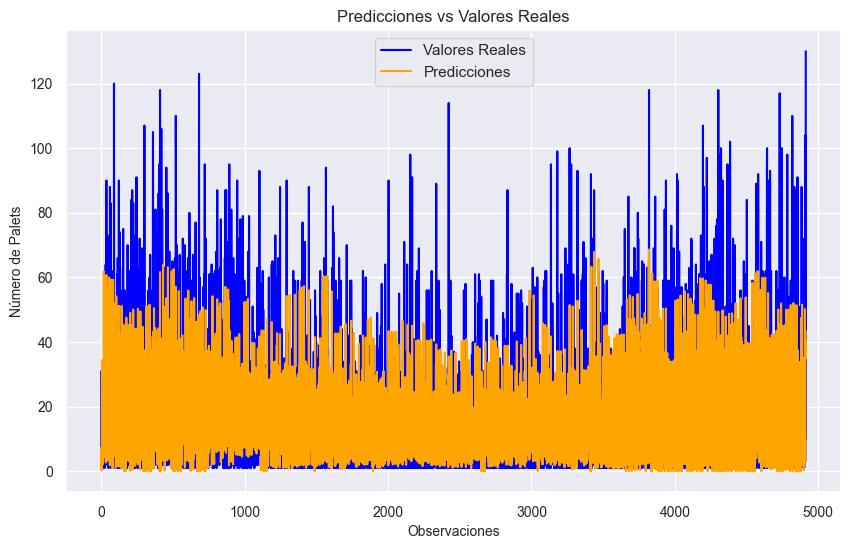

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='Valores Reales', color='blue')
plt.plot(y_pred, label='Predicciones', color='orange')
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Observaciones')
plt.ylabel('Número de Palets')
plt.legend()
plt.show()

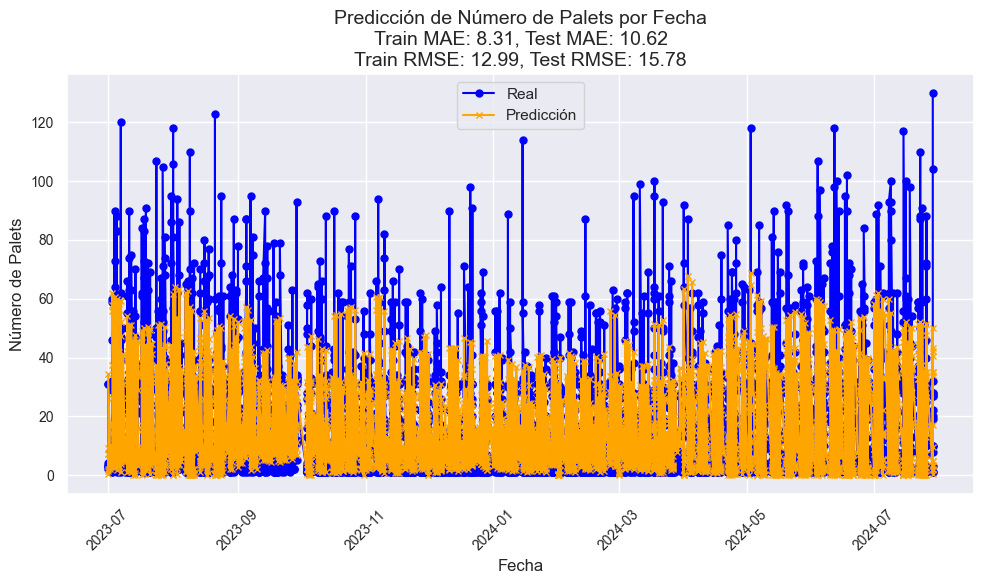

In [ ]:
real_vs_pred_diario = pd.DataFrame({
    'day': X_test.index,
    'numero_pales': y_test.values,
    'predicted_pales': y_pred
})

plt.figure(figsize=(10, 6))
plt.plot(real_vs_pred_diario['day'], real_vs_pred_diario['numero_pales'], label='Real', marker='o', color='blue', markersize=5)
plt.plot(real_vs_pred_diario['day'], real_vs_pred_diario['predicted_pales'], label='Predicción', marker='x', color='orange', markersize=5)

plt.title(f"Predicción de Número de Palets por Fecha\nTrain MAE: {mae_dia_train:.2f}, Test MAE: {mae_dia_test:.2f}\nTrain RMSE: {rmse_dia_train:.2f}, Test RMSE: {rmse_dia_test:.2f}", fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Palets', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Prediccion diaria con el model_dia

Se realizará la predicción utilizando el **model_dia** creado anteriormente, para esto se debe establecer en correcto orden las variables dependientes de entrada que recibirá el modelo.
Se colocan las variables del df_predicción en **el mismo orden** que las ha recibido el modelo en la parte de entrenamiento del modelo

In [ ]:
print(X_train.columns)

Index(['region_destino_final_freq', 'id_tipo_transporte_freq',
       'transporte_destino', 'ano', 'mes', 'dia', 'semana',
       'promedio_numero_pales_mensual', 'promedio_numero_pales_semanal',
       'promedio_envios_diario_transporte_destino'],
      dtype='object')


In [ ]:
print(df_prediccion_dia.columns)

Index(['fecha', 'transporte_destino', 'region_destino_final_freq',
       'id_tipo_transporte_freq', 'ano', 'mes', 'dia', 'semana',
       'promedio_envios_diario_transporte_destino',
       'promedio_numero_pales_semanal', 'promedio_numero_pales_mensual'],
      dtype='object')


In [ ]:
df_prediccion_dia.drop(['fecha'],axis= 1,inplace=True)

In [ ]:
df_prediccion_dia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26520 entries, 0 to 26519
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   region_destino_final_freq                  26520 non-null  float64
 1   id_tipo_transporte_freq                    26520 non-null  float64
 2   transporte_destino                         26520 non-null  int32  
 3   ano                                        26520 non-null  int32  
 4   mes                                        26520 non-null  int32  
 5   dia                                        26520 non-null  int32  
 6   semana                                     26520 non-null  UInt32 
 7   promedio_numero_pales_mensual              26520 non-null  float64
 8   promedio_numero_pales_semanal              26520 non-null  float64
 9   promedio_envios_diario_transporte_destino  26520 non-null  float64
dtypes: UInt32(1), float64(

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10181 entries, 2021-01-01 to 2023-06-30
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   region_destino_final_freq                  10181 non-null  float64
 1   id_tipo_transporte_freq                    10181 non-null  float64
 2   transporte_destino                         10181 non-null  int32  
 3   ano                                        10181 non-null  int32  
 4   mes                                        10181 non-null  int32  
 5   dia                                        10181 non-null  int32  
 6   semana                                     10181 non-null  UInt32 
 7   promedio_numero_pales_mensual              10181 non-null  float64
 8   promedio_numero_pales_semanal              10181 non-null  float64
 9   promedio_envios_diario_transporte_destino  10181 non-null  float64
dtypes: UI

Es necesario ordenar las columnas para el modelo

In [ ]:
nuevo_orden = [
    'region_destino_final_freq',
    'id_tipo_transporte_freq',
    'transporte_destino',
    'ano',
    'mes',
    'dia',
    'semana',
    'promedio_numero_pales_mensual',
    'promedio_numero_pales_semanal',
    'promedio_envios_diario_transporte_destino'
]

In [ ]:
df_prediccion_dia = df_prediccion_dia[nuevo_orden]

Se crea un nuevo dataset donde **se guardará la predicción** el resultado del modelo

In [ ]:
#creamos un nuevo dataset donde guardar toda la prediccion
df_prediccion_diaria = df_prediccion_dia.copy()

Se predice en base al dataframe **prediccion para el 2024-2025** la variable **numero_pales**

In [ ]:
df_prediccion_diaria['numero_pales'] = model_dia.predict(df_prediccion_dia)

In [ ]:
print(df_prediccion_diaria[['numero_pales']])

       numero_pales
0          7.526689
1          7.369479
2          6.109695
3          9.380346
4         22.915239
...             ...
26515     37.877032
26516      3.419367
26517      1.418744
26518     37.202737
26519      1.926990

[26520 rows x 1 columns]


In [ ]:
df_prediccion_diaria

,region_destino_final_freq,id_tipo_transporte_freq,transporte_destino,ano,mes,dia,semana,promedio_numero_pales_mensual,promedio_numero_pales_semanal,promedio_envios_diario_transporte_destino,numero_pales
0,0.075998,0.457827,14,2024,7,30,31,8541.0,1667.0,1.808843,7.526689
1,0.081768,0.457827,5,2024,7,30,31,8541.0,1667.0,1.787190,7.369479
2,0.119705,0.457827,20,2024,7,30,31,8541.0,1667.0,1.617391,6.109695
3,0.120156,0.457827,17,2024,7,30,31,8541.0,1667.0,1.494324,9.380346
4,0.157929,0.457827,24,2024,7,30,31,8541.0,1667.0,1.875269,22.915239
...,...,...,...,...,...,...,...,...,...,...,...
26515,0.000205,0.000082,0,2025,12,31,1,4330.0,838.0,1.000000,37.877032
26516,0.002947,0.541968,29,2025,12,31,1,4330.0,838.0,1.000000,3.419367
26517,0.003438,0.541968,45,2025,12,31,1,4330.0,838.0,1.000000,1.418744
26518,0.021608,0.457827,1,2025,12,31,1,4330.0,838.0,1.000000,37.202737


Para tener la información completa y sin codificar que se requiere, se eliminan aquellas variables que no sean útiles y se añaden los datos de provincia destino final y tipo de transporte al dataframe de la predicción.

In [ ]:
df_prediccion_diaria = df_prediccion_diaria.merge(df_provincias[['provincia_destino_final', 'region_destino_final','id_tipo_transporte', 'transporte_destino']],
                                    on=['transporte_destino'],
                                    how='left')

In [ ]:
df_prediccion_diaria.drop(columns=['region_destino_final_freq'],axis= 1,inplace=True)
df_prediccion_diaria.drop(columns=['id_tipo_transporte_freq'],axis= 1,inplace=True)
df_prediccion_diaria.drop(columns=['transporte_destino'],axis= 1,inplace=True)
df_prediccion_diaria.drop(columns=['promedio_envios_diario_transporte_destino'],axis= 1,inplace=True)
df_prediccion_diaria.drop(columns=['promedio_numero_pales_semanal'],axis= 1,inplace=True)
df_prediccion_diaria.drop(columns=['promedio_numero_pales_mensual'],axis= 1,inplace=True)

In [ ]:
df_prediccion_diaria

,ano,mes,dia,semana,numero_pales,provincia_destino_final,region_destino_final,id_tipo_transporte
0,2024,7,30,31,7.526689,Cantabria,39,1
1,2024,7,30,31,7.369479,Guadalajara,19,1
2,2024,7,30,31,6.109695,Valencia,46,1
3,2024,7,30,31,9.380346,Sevilla,41,1
4,2024,7,30,31,22.915239,Barcelona,8,1
...,...,...,...,...,...,...,...,...
26515,2025,12,31,1,37.877032,Las Palmas,35,11
26516,2025,12,31,1,3.419367,Granada,18,3
26517,2025,12,31,1,1.418744,Valladolid,47,3
26518,2025,12,31,1,37.202737,Álava,1,1


Se crea un gráfico con los datos históricos en azul y las predicciones a futuro en rojo, alineados temporalmente.

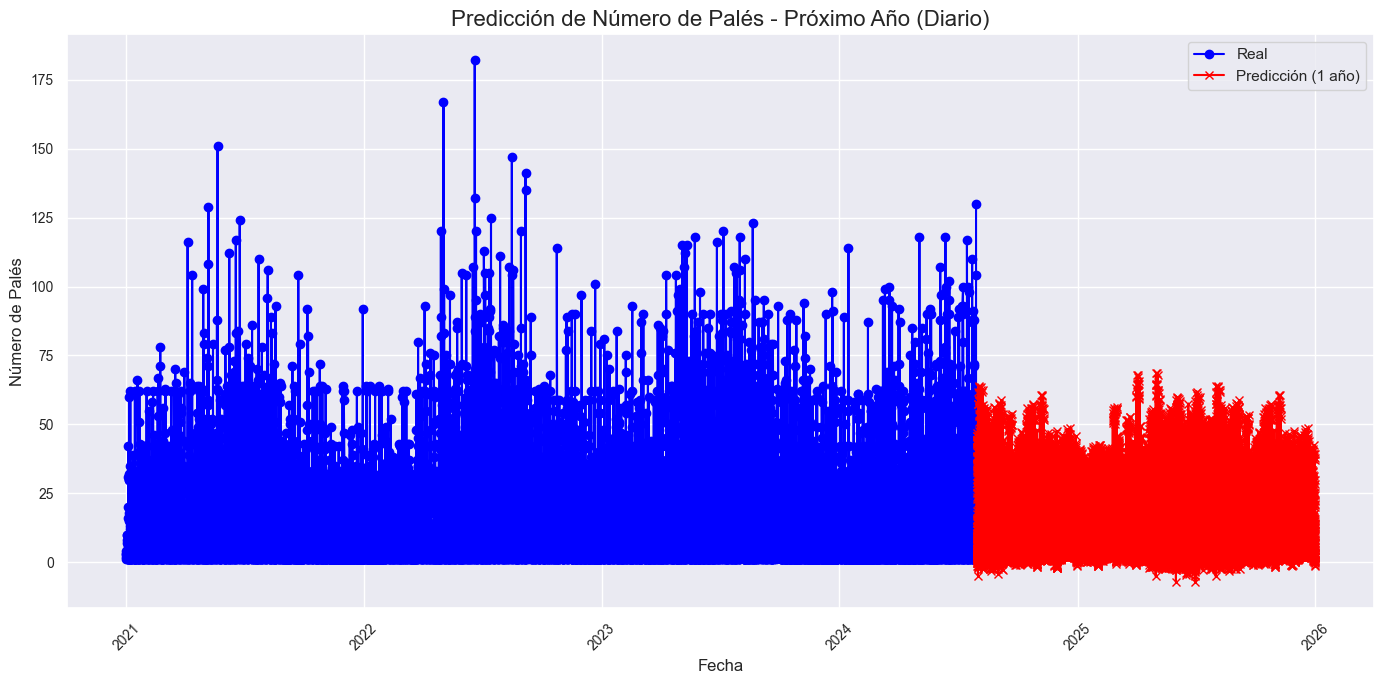

In [ ]:
df_real = df_dia[['fecha', 'numero_pales']].copy()
df_pred = df_prediccion_diaria[['ano', 'mes', 'dia', 'numero_pales']].copy()


df_pred['fecha'] = pd.to_datetime(df_pred[['ano', 'mes', 'dia']].rename(columns={'ano': 'year', 'mes': 'month', 'dia': 'day'}))
df_combined = pd.concat([df_real, df_pred[['fecha', 'numero_pales']]], ignore_index=True)
df_combined['tipo'] = ['Real'] * len(df_real) + ['Predicción'] * len(df_pred)

plt.figure(figsize=(14, 7))
plt.plot(df_combined[df_combined['tipo'] == 'Real']['fecha'],
         df_combined[df_combined['tipo'] == 'Real']['numero_pales'],
         label='Real', color='blue', marker='o', linestyle='-')
plt.plot(df_combined[df_combined['tipo'] == 'Predicción']['fecha'],
         df_combined[df_combined['tipo'] == 'Predicción']['numero_pales'],
         label='Predicción (1 año)', color='red', marker='x', linestyle='-')

plt.title('Predicción de Número de Palés - Próximo Año (Diario)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Palés', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


**Se guarda el dataframe de predicción diario en un archivo csv para analizar su contenido**

In [ ]:
df_prediccion_diaria.to_csv('df_prediccion_diaria_lgbm.csv', index=False)

print("El DataFrame se ha guardado en 'df_prediccion_diaria_lgbm.csv'")

El DataFrame se ha guardado en 'df_prediccion_diaria_lgbm.csv'


### 4.2 Modelo lightGBM para los datos agrupados semanalmente

In [ ]:
df_final

,fecha,region_destino_final_freq,id_tipo_transporte_freq,transporte_destino,ano,mes,dia,semana,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales,envios,promedio_envios_diario_transporte_destino
0,2021-01-01,0.075998,0.457827,14,2021,1,1,53,4447.0,50.0,3,1,1.808843
1,2021-01-01,0.081768,0.457827,5,2021,1,1,53,4447.0,50.0,4,1,1.787190
2,2021-01-01,0.119705,0.457827,20,2021,1,1,53,4447.0,50.0,1,1,1.617391
3,2021-01-01,0.120156,0.457827,17,2021,1,1,53,4447.0,50.0,3,1,1.494324
4,2021-01-01,0.157929,0.457827,24,2021,1,1,53,4447.0,50.0,2,1,1.875269
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15090,2024-07-29,0.075998,0.541968,40,2024,7,29,31,8541.0,1667.0,3,1,1.283747
15091,2024-07-29,0.119705,0.541968,44,2024,7,29,31,8541.0,1667.0,104,6,1.871094
15092,2024-07-29,0.120156,0.541968,41,2024,7,29,31,8541.0,1667.0,10,2,1.955322
15093,2024-07-29,0.136853,0.541968,33,2024,7,29,31,8541.0,1667.0,28,5,2.771547


Se separa el dataframe en lo que sería la **parte de entrenamiento y la parte de prueba**, definiendo las fechas para cada periodo.

In [ ]:
fecha_inicio = '2023-07-01'
fecha_fin = '2024-07-29'

df_train_semana = df_final[~((df_final['fecha'] >= fecha_inicio) & (df_final['fecha'] <= fecha_fin))]

df_test_semana = df_final[(df_final['fecha'] >= fecha_inicio) & (df_final['fecha'] <= fecha_fin) ]

Se agrupa según las variables mencionadas a continuación y se obtiene un promedio de envios semanales y el numero de pales enviados semanalmente

In [ ]:
df_envios_semanaltrain = df_train_semana.groupby(['ano', 'mes','semana', 'transporte_destino','id_tipo_transporte_freq','region_destino_final_freq','promedio_numero_pales_mensual','promedio_numero_pales_semanal']).agg(
    numero_pales=('numero_pales', 'sum')
).reset_index()


df_envios_semanaltest = df_test_semana.groupby(['ano', 'mes','semana', 'transporte_destino','id_tipo_transporte_freq','region_destino_final_freq','promedio_numero_pales_mensual','promedio_numero_pales_semanal']).agg(
    numero_pales=('numero_pales', 'sum')
).reset_index()


In [ ]:
df_envios_semanaltrain

,ano,mes,semana,transporte_destino,id_tipo_transporte_freq,region_destino_final_freq,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales
0,2021,1,1,2,0.457827,0.049355,4447.0,838.0,62
1,2021,1,1,5,0.457827,0.081768,4447.0,838.0,65
2,2021,1,1,9,0.457827,0.136853,4447.0,838.0,48
3,2021,1,1,12,0.457827,0.071741,4447.0,838.0,42
4,2021,1,1,14,0.457827,0.075998,4447.0,838.0,31
...,...,...,...,...,...,...,...,...,...
3741,2023,6,26,43,0.541968,0.023450,7800.0,1780.0,4
3742,2023,6,26,44,0.541968,0.119705,7800.0,1780.0,149
3743,2023,6,26,47,0.541968,0.020544,7800.0,1780.0,3
3744,2023,6,26,48,0.541968,0.157929,7800.0,1780.0,151


In [ ]:
df_envios_semanaltest

,ano,mes,semana,transporte_destino,id_tipo_transporte_freq,region_destino_final_freq,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales
0,2023,7,26,5,0.457827,0.081768,8541.0,1780.0,8
1,2023,7,26,14,0.457827,0.075998,8541.0,1780.0,5
2,2023,7,26,17,0.457827,0.120156,8541.0,1780.0,6
3,2023,7,26,20,0.457827,0.119705,8541.0,1780.0,4
4,2023,7,26,24,0.457827,0.157929,8541.0,1780.0,6
...,...,...,...,...,...,...,...,...,...
1841,2024,7,31,44,0.541968,0.119705,8541.0,1667.0,104
1842,2024,7,31,45,0.541968,0.003438,8541.0,1667.0,1
1843,2024,7,31,47,0.541968,0.020544,8541.0,1667.0,22
1844,2024,7,31,48,0.541968,0.157929,8541.0,1667.0,130


Tanto del dataframe X_Train y X_Test se elimina la variable objetivo, en este caso **numero_pales**

Y en los dataframes Y_train y Y_test se conserva unicamente la variable **numero_pales**

In [ ]:
X_train2= df_envios_semanaltrain.drop(columns=['numero_pales'])
X_test2 =df_envios_semanaltest.drop(columns=['numero_pales'])
y_train2 = df_envios_semanaltrain['numero_pales']
y_test2 = df_envios_semanaltest['numero_pales']

In [ ]:
X_train2.head()

,ano,mes,semana,transporte_destino,id_tipo_transporte_freq,region_destino_final_freq,promedio_numero_pales_mensual,promedio_numero_pales_semanal
0,2021,1,1,2,0.457827,0.049355,4447.0,838.0
1,2021,1,1,5,0.457827,0.081768,4447.0,838.0
2,2021,1,1,9,0.457827,0.136853,4447.0,838.0
3,2021,1,1,12,0.457827,0.071741,4447.0,838.0
4,2021,1,1,14,0.457827,0.075998,4447.0,838.0


Transformamos los dataframes en el formato que nos exige el modelo **LightGBM**

In [ ]:
train_data2 = lgb.Dataset(X_train2, label=y_train2)
test_data2 = lgb.Dataset(X_test2, label=y_test2)

Establecemos los parámetros del modelo

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'verbose': -1
}

Creamos el **model_semana** y lo entrenamos con los datos definidos previamente

In [ ]:
model_semana = lgb.train(params,
                  train_data2,
                  num_boost_round=1000,
                  valid_sets=[test_data2],
                  valid_names=['test'])  # Sin early stopping


Hacemos las predicciones con el conjunto de prueba estableciendo que los valores de la prediccion deben ser mayores a 0

In [ ]:
y_pred2 = model_semana.predict(X_test2, num_iteration=model_semana.best_iteration)
y_pred2[y_pred2 < 0] = 0

Obtenemos las **métricas del model_semana** para analizar sus resultados  

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_train_pred = model_semana.predict(X_train2)

rmse_semana_train = np.sqrt(mean_squared_error(y_train2, y_train_pred))
mae_semana_train = mean_absolute_error(y_train2, y_train_pred)
r2_semana_train = r2_score(y_train2, y_train_pred)

rmse_semana_test = np.sqrt(mean_squared_error(y_test2, y_pred2))
mae_semana_test = mean_absolute_error(y_test2, y_pred2)
r2_semana_test = r2_score(y_test2, y_pred2)

print(f'Métricas para el modelo:')
print(f"MAE_train: {mae_semana_train:.2f}, Train RMSE: {rmse_semana_train:.2f},R²_train: {r2_semana_train:.2f} ")
print(f"MAE_test: {mae_semana_test:.2f}, Test RMSE: {rmse_semana_test:.2f}, R²_test:{r2_semana_test:.2f} ")


Métricas para el modelo:
MAE_train: 14.03, Train RMSE: 21.16,R²_train: 0.84 
MAE_test: 19.78, Test RMSE: 30.31, R²_test:0.68 


Graficamos los datos **Reales** vs **Predicción** que se obtuvo del modelo

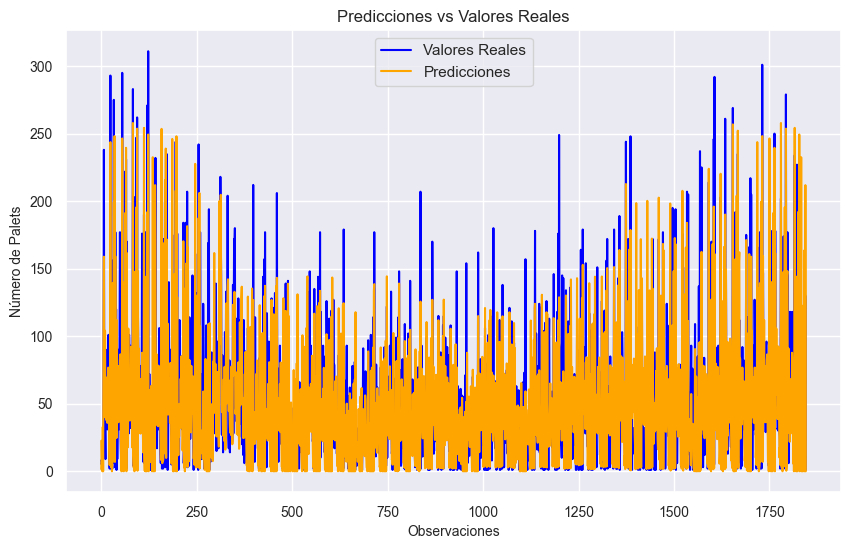

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test2.reset_index(drop=True), label='Valores Reales', color='blue')
plt.plot(y_pred2, label='Predicciones', color='orange')
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Observaciones')
plt.ylabel('Número de Palets')
plt.legend()
plt.show()


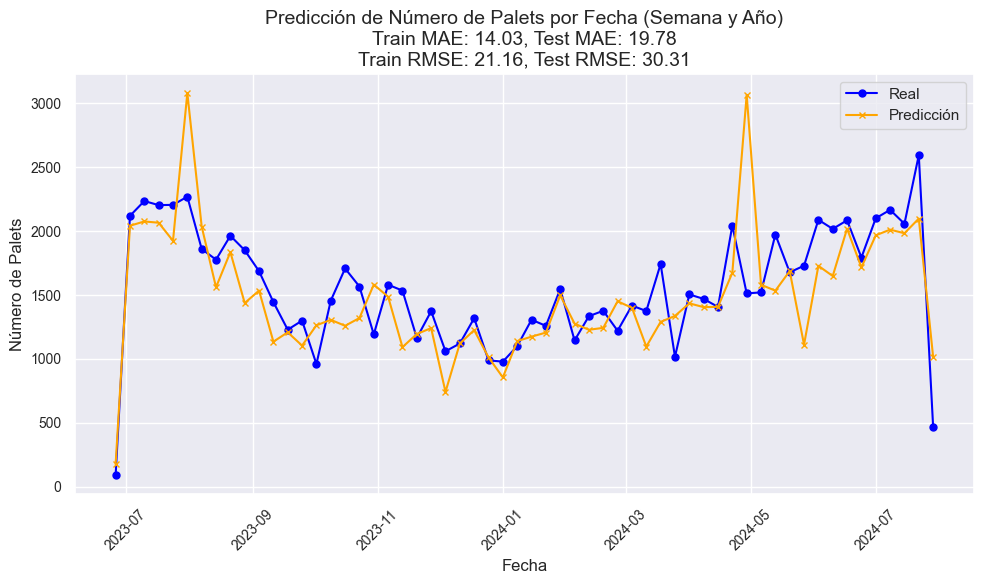

In [ ]:
X_test2['fecha'] = pd.to_datetime(X_test2['ano'].astype(str) + '-W' + X_test2['semana'].astype(str) + '-1', format='%Y-W%W-%w')


real_vs_pred_semanal = pd.DataFrame({
    'fecha': X_test2['fecha'],
    'numero_pales': y_test2.values,
    'predicted_pales': y_pred2,
    'zona_destino': X_test2['region_destino_final_freq'],
    'tipo_transporte': X_test2['id_tipo_transporte_freq']
})

real_vs_pred_agrupado = real_vs_pred_semanal.groupby(['fecha']).sum().reset_index()

plt.figure(figsize=(10, 6))

plt.plot(real_vs_pred_agrupado['fecha'], real_vs_pred_agrupado['numero_pales'], label='Real', marker='o', color='blue', markersize=5)
plt.plot(real_vs_pred_agrupado['fecha'], real_vs_pred_agrupado['predicted_pales'], label='Predicción', marker='x', color='orange', markersize=5)

plt.title(f"Predicción de Número de Palets por Fecha (Semana y Año)\nTrain MAE: {mae_semana_train:.2f}, Test MAE: {mae_semana_test:.2f}\nTrain RMSE: {rmse_semana_train:.2f}, Test RMSE: {rmse_semana_test:.2f}", fontsize=14)


plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Palets', fontsize=12)


plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


**Se guarda el modelo en un pickle**

In [ ]:
model_name = "model_semana"

with open(f"{model_name}.dat", "wb") as file:
    pickle.dump(model_semana, file)

print(f"{model_name}.dat")

model_semana.dat


**Se abre el modelo para utilizarlo en la predicción semanal**

In [ ]:
with open("model_semana.dat", "rb") as file:
    model_semana = pickle.load(file)

Se revisa que el dataframe de predicción mes tenga las mismas variables que el de entrenamiento y se eliminan aquellas que no nos sirvan.

In [ ]:
df_prediccion_semanal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4590 entries, 0 to 26417
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ano                            4590 non-null   int32  
 1   mes                            4590 non-null   int32  
 2   semana                         4590 non-null   UInt32 
 3   transporte_destino             4590 non-null   int32  
 4   region_destino_final_freq      4590 non-null   float64
 5   id_tipo_transporte_freq        4590 non-null   float64
 6   promedio_numero_pales_semanal  4590 non-null   float64
 7   promedio_numero_pales_mensual  4590 non-null   float64
dtypes: UInt32(1), float64(4), int32(3)
memory usage: 255.5 KB


In [ ]:
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3746 entries, 0 to 3745
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ano                            3746 non-null   int32  
 1   mes                            3746 non-null   int32  
 2   semana                         3746 non-null   UInt32 
 3   transporte_destino             3746 non-null   int32  
 4   id_tipo_transporte_freq        3746 non-null   float64
 5   region_destino_final_freq      3746 non-null   float64
 6   promedio_numero_pales_mensual  3746 non-null   float64
 7   promedio_numero_pales_semanal  3746 non-null   float64
dtypes: UInt32(1), float64(4), int32(3)
memory usage: 179.4 KB


#### Prediccion semanal con el model_semana

In [ ]:
df_prediccion_semana = df_prediccion_semanal.copy()

In [ ]:
df_prediccion_semana.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4590 entries, 0 to 26417
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ano                            4590 non-null   int32  
 1   mes                            4590 non-null   int32  
 2   semana                         4590 non-null   UInt32 
 3   transporte_destino             4590 non-null   int32  
 4   region_destino_final_freq      4590 non-null   float64
 5   id_tipo_transporte_freq        4590 non-null   float64
 6   promedio_numero_pales_semanal  4590 non-null   float64
 7   promedio_numero_pales_mensual  4590 non-null   float64
dtypes: UInt32(1), float64(4), int32(3)
memory usage: 255.5 KB


In [ ]:
nuevo_orden = [
    'ano',
    'mes',
     'semana',
    'transporte_destino',
    'id_tipo_transporte_freq',
    'region_destino_final_freq',
    'promedio_numero_pales_mensual',
    'promedio_numero_pales_semanal',
]

In [ ]:
df_prediccion_semana = df_prediccion_semana[nuevo_orden]

Obtenemos la prediccion semanal de la columna numero_pales y almacenamos los resultados en un csv.

In [ ]:
df_prediccion_semana['numero_pales'] = model_semana.predict(df_prediccion_semana)
df_prediccion_semana['numero_pales'] = np.maximum(df_prediccion_semana['numero_pales'], 0)

In [ ]:
df_prediccion_semana

,ano,mes,semana,transporte_destino,id_tipo_transporte_freq,region_destino_final_freq,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales
0,2024,7,31,14,0.457827,0.075998,8541.0,1667.0,6.799622
1,2024,7,31,5,0.457827,0.081768,8541.0,1667.0,32.930758
2,2024,7,31,20,0.457827,0.119705,8541.0,1667.0,6.845968
3,2024,7,31,17,0.457827,0.120156,8541.0,1667.0,23.595933
4,2024,7,31,24,0.457827,0.157929,8541.0,1667.0,63.209921
...,...,...,...,...,...,...,...,...,...
26413,2025,12,1,0,0.000082,0.000205,4330.0,838.0,14.186728
26414,2025,12,1,29,0.541968,0.002947,4330.0,838.0,0.000000
26415,2025,12,1,45,0.541968,0.003438,4330.0,838.0,0.000000
26416,2025,12,1,1,0.457827,0.021608,4330.0,838.0,104.073413


Eliminamos las variables que no queremos almacenar en nuestro archivo final

In [ ]:
df_prediccion_semana = df_prediccion_semana.merge(df_provincias[['provincia_destino_final', 'region_destino_final','id_tipo_transporte', 'transporte_destino']],
                                    on=['transporte_destino'],
                                    how='left')

In [ ]:
df_prediccion_semana.drop(columns=['region_destino_final_freq'],axis= 1,inplace=True)
df_prediccion_semana.drop(columns=['id_tipo_transporte_freq'],axis= 1,inplace=True)
df_prediccion_semana.drop(columns=['transporte_destino'],axis= 1,inplace=True)
df_prediccion_semana.drop(columns=['promedio_numero_pales_semanal'],axis= 1,inplace=True)
df_prediccion_semana.drop(columns=['promedio_numero_pales_mensual'],axis= 1,inplace=True)

In [ ]:
df_prediccion_semana

,ano,mes,semana,numero_pales,provincia_destino_final,region_destino_final,id_tipo_transporte
0,2024,7,31,6.799622,Cantabria,39,1
1,2024,7,31,32.930758,Guadalajara,19,1
2,2024,7,31,6.845968,Valencia,46,1
3,2024,7,31,23.595933,Sevilla,41,1
4,2024,7,31,63.209921,Barcelona,8,1
...,...,...,...,...,...,...,...
4585,2025,12,1,14.186728,Las Palmas,35,11
4586,2025,12,1,0.000000,Granada,18,3
4587,2025,12,1,0.000000,Valladolid,47,3
4588,2025,12,1,104.073413,Álava,1,1


In [ ]:
df_prediccion_semana.to_csv('df_prediccion_semanal_lgbm.csv', index=False)

print("El DataFrame se ha guardado en 'df_prediccion_semanal_lgbm.csv'")

El DataFrame se ha guardado en 'df_prediccion_semanal_lgbm.csv'


Se crea un gráfico con los datos históricos en azul y las predicciones a futuro en rojo, alineados temporalmente.

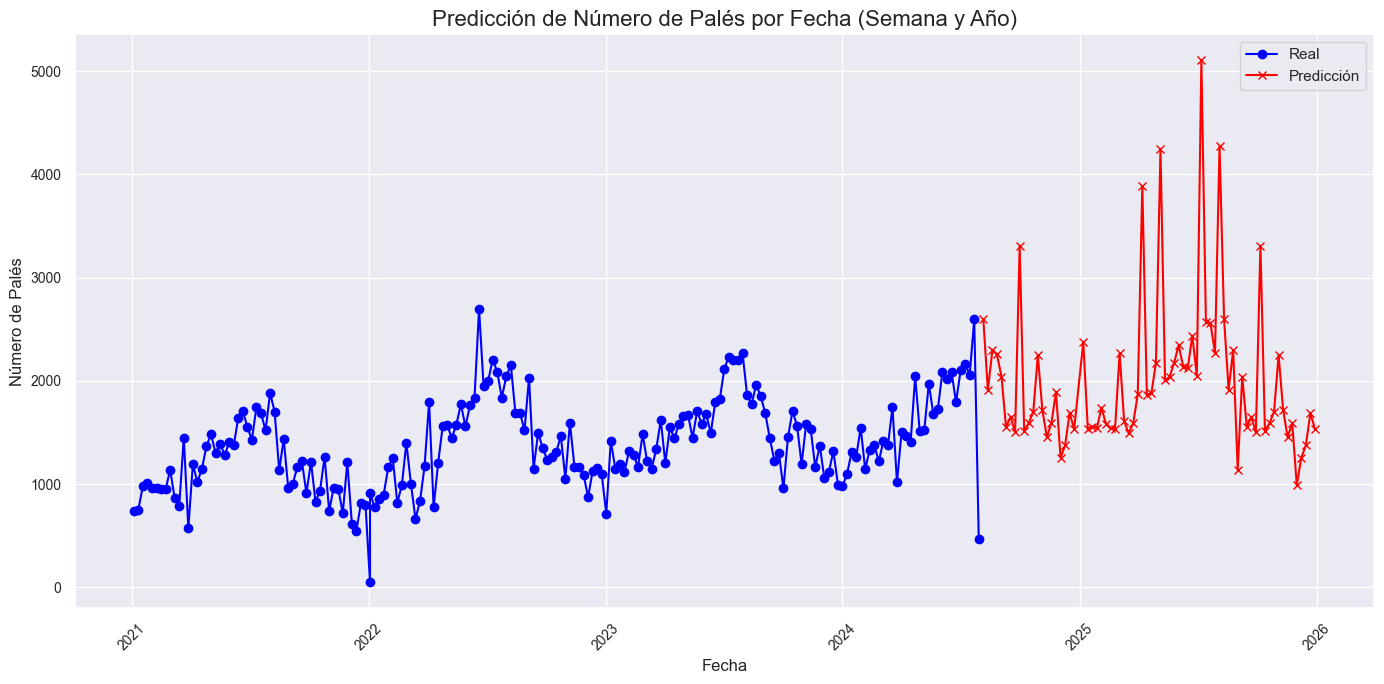

In [ ]:
df_prediccion_semanal_copy = df_prediccion_semana.copy()

df_prediccion_semanal_grouped = df_prediccion_semanal_copy.groupby(['ano', 'semana']).agg({'numero_pales': 'sum'}).reset_index()

df_prediccion_semanal_grouped['Fecha'] = pd.to_datetime(df_prediccion_semanal_grouped['ano'].astype(str) + df_prediccion_semanal_grouped['semana'].astype(str) + '1', format='%Y%W%w')

fecha_maxima_real = df_final['fecha'].max()

df_historico_semanal = df_final[df_final['fecha'] <= fecha_maxima_real].groupby(['ano', 'semana']).agg({'numero_pales': 'sum'}).reset_index()

df_historico_semanal['Fecha'] = pd.to_datetime(df_historico_semanal['ano'].astype(str) + df_historico_semanal['semana'].astype(str) + '1', format='%Y%W%w')

df_prediccion_semanal_grouped = df_prediccion_semanal_grouped[df_prediccion_semanal_grouped['Fecha'] > fecha_maxima_real]

plt.figure(figsize=(14, 7))

plt.plot(df_historico_semanal['Fecha'], df_historico_semanal['numero_pales'], label='Real', marker='o', color='blue')
plt.plot(df_prediccion_semanal_grouped['Fecha'], df_prediccion_semanal_grouped['numero_pales'], label='Predicción', marker='x', color='red')

plt.title('Predicción de Número de Palés por Fecha (Semana y Año)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Palés', fontsize=12)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4.3 Modelo lightGBM para los datos agrupados mensualmente

A partir del dataframe final, separamos nuestros dataframes de train y test según las fechas especificadas. Posteriormente agrupamos a nivel mensual

In [ ]:
df_final

,fecha,region_destino_final_freq,id_tipo_transporte_freq,transporte_destino,ano,mes,dia,semana,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales,envios,promedio_envios_diario_transporte_destino
0,2021-01-01,0.075998,0.457827,14,2021,1,1,53,4447.0,50.0,3,1,1.808843
1,2021-01-01,0.081768,0.457827,5,2021,1,1,53,4447.0,50.0,4,1,1.787190
2,2021-01-01,0.119705,0.457827,20,2021,1,1,53,4447.0,50.0,1,1,1.617391
3,2021-01-01,0.120156,0.457827,17,2021,1,1,53,4447.0,50.0,3,1,1.494324
4,2021-01-01,0.157929,0.457827,24,2021,1,1,53,4447.0,50.0,2,1,1.875269
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15090,2024-07-29,0.075998,0.541968,40,2024,7,29,31,8541.0,1667.0,3,1,1.283747
15091,2024-07-29,0.119705,0.541968,44,2024,7,29,31,8541.0,1667.0,104,6,1.871094
15092,2024-07-29,0.120156,0.541968,41,2024,7,29,31,8541.0,1667.0,10,2,1.955322
15093,2024-07-29,0.136853,0.541968,33,2024,7,29,31,8541.0,1667.0,28,5,2.771547


In [ ]:
#Se separa el dataframe en test y train
fecha_inicio = '2023-07-01'
fecha_fin = '2024-07-29'

df_train_mes = df_final[~((df_final['fecha'] >= fecha_inicio) & (df_final['fecha'] <= fecha_fin))]

df_test_mes = df_final[(df_final['fecha'] >= fecha_inicio) & (df_final['fecha'] <= fecha_fin) ]

In [ ]:
df_train_mes

,fecha,region_destino_final_freq,id_tipo_transporte_freq,transporte_destino,ano,mes,dia,semana,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales,envios,promedio_envios_diario_transporte_destino
0,2021-01-01,0.075998,0.457827,14,2021,1,1,53,4447.0,50.0,3,1,1.808843
1,2021-01-01,0.081768,0.457827,5,2021,1,1,53,4447.0,50.0,4,1,1.787190
2,2021-01-01,0.119705,0.457827,20,2021,1,1,53,4447.0,50.0,1,1,1.617391
3,2021-01-01,0.120156,0.457827,17,2021,1,1,53,4447.0,50.0,3,1,1.494324
4,2021-01-01,0.157929,0.457827,24,2021,1,1,53,4447.0,50.0,2,1,1.875269
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10176,2023-06-30,0.120156,0.541968,41,2023,6,30,26,7800.0,1780.0,30,2,1.955322
10177,2023-06-30,0.136853,0.457827,9,2023,6,30,26,7800.0,1780.0,25,2,1.288168
10178,2023-06-30,0.136853,0.541968,33,2023,6,30,26,7800.0,1780.0,82,5,2.771547
10179,2023-06-30,0.157929,0.457827,24,2023,6,30,26,7800.0,1780.0,51,4,1.875269


In [ ]:
df_test_mes

,fecha,region_destino_final_freq,id_tipo_transporte_freq,transporte_destino,ano,mes,dia,semana,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales,envios,promedio_envios_diario_transporte_destino
10181,2023-07-01,0.049355,0.541968,27,2023,7,1,26,8541.0,1780.0,31,1,1.176904
10182,2023-07-01,0.075998,0.457827,14,2023,7,1,26,8541.0,1780.0,3,1,1.808843
10183,2023-07-01,0.081768,0.457827,5,2023,7,1,26,8541.0,1780.0,4,1,1.787190
10184,2023-07-01,0.119705,0.457827,20,2023,7,1,26,8541.0,1780.0,2,1,1.617391
10185,2023-07-01,0.120156,0.457827,17,2023,7,1,26,8541.0,1780.0,3,1,1.494324
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15090,2024-07-29,0.075998,0.541968,40,2024,7,29,31,8541.0,1667.0,3,1,1.283747
15091,2024-07-29,0.119705,0.541968,44,2024,7,29,31,8541.0,1667.0,104,6,1.871094
15092,2024-07-29,0.120156,0.541968,41,2024,7,29,31,8541.0,1667.0,10,2,1.955322
15093,2024-07-29,0.136853,0.541968,33,2024,7,29,31,8541.0,1667.0,28,5,2.771547


Hacemos la agrupación y sumamos la variable objetivo a nivel **mes**

In [ ]:
df_enviosmestrain = df_train_mes.groupby(['ano', 'mes', 'transporte_destino','id_tipo_transporte_freq','region_destino_final_freq','promedio_numero_pales_mensual']).agg(
    numero_pales=('numero_pales', 'sum')
).reset_index()

df_enviosmestest = df_test_mes.groupby(['ano', 'mes', 'transporte_destino','id_tipo_transporte_freq','region_destino_final_freq','promedio_numero_pales_mensual']).agg(
    numero_pales=('numero_pales', 'sum')
).reset_index()



Tanto del data frame Train y Test quitamos la variable objetivo, en este caso **numero_pales**

In [ ]:
X_train3= df_enviosmestrain.drop(columns=['numero_pales'])
X_test3 =df_enviosmestest.drop(columns=['numero_pales'])
y_train3 = df_enviosmestrain['numero_pales']
y_test3 = df_enviosmestest['numero_pales']

En este modelo usaremos un **lightGBM** por lo que los dataframes deben estar en un formato especifico para este modelo.
Hacemos la transformación:

In [ ]:
train_data3 = lgb.Dataset(X_train3, label=y_train3)
test_data3 = lgb.Dataset(X_test3, label=y_test3)

Establecemos los parámetros que recibirá nuestro modelo **LightGBM**

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'verbose': -1
}

Creamos el **model_mes** , que recibe los parámetros definidos anteriormente

In [ ]:
model_mes = lgb.train(params,
                  train_data3,
                  num_boost_round=1000,
                  valid_sets=[test_data3],
                  valid_names=['test'])  # Sin early stopping


In [ ]:
X_train3

,ano,mes,transporte_destino,id_tipo_transporte_freq,region_destino_final_freq,promedio_numero_pales_mensual
0,2021,1,2,0.457827,0.049355,4447.0
1,2021,1,5,0.457827,0.081768,4447.0
2,2021,1,7,0.457827,0.008758,4447.0
3,2021,1,8,0.457827,0.000205,4447.0
4,2021,1,9,0.457827,0.136853,4447.0
...,...,...,...,...,...,...
903,2023,6,43,0.541968,0.023450,7800.0
904,2023,6,44,0.541968,0.119705,7800.0
905,2023,6,47,0.541968,0.020544,7800.0
906,2023,6,48,0.541968,0.157929,7800.0


In [ ]:
X_test3

,ano,mes,transporte_destino,id_tipo_transporte_freq,region_destino_final_freq,promedio_numero_pales_mensual
0,2023,7,2,0.457827,0.049355,8541.0
1,2023,7,5,0.457827,0.081768,8541.0
2,2023,7,9,0.457827,0.136853,8541.0
3,2023,7,10,0.457827,0.015920,8541.0
4,2023,7,12,0.457827,0.071741,8541.0
...,...,...,...,...,...,...
429,2024,7,45,0.541968,0.003438,8541.0
430,2024,7,47,0.541968,0.020544,8541.0
431,2024,7,48,0.541968,0.157929,8541.0
432,2024,7,49,0.541968,0.016534,8541.0


Hacemos la predicción con el modelo definido en la celda anterior, establecemos que las predicciones no sean menores a 0

In [ ]:
# Se hacen predicciones en el conjunto de prueba
y_pred3 = model_mes.predict(X_test3, num_iteration=model_mes.best_iteration)
y_pred3[y_pred3 < 0] = 0

**Obtenemos las métricas para analizar el modelo y sus resultados**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_train_pred = model_mes.predict(X_train3)

rmse_mes_train = np.sqrt(mean_squared_error(y_train3, y_train_pred))
mae_mes_train = mean_absolute_error(y_train3, y_train_pred)
r2_mes_train = r2_score(y_train3, y_train_pred)

rmse_mes_test = np.sqrt(mean_squared_error(y_test3, y_pred3))
mae_mes_test = mean_absolute_error(y_test3, y_pred3)
r2_mes_test = r2_score(y_test3, y_pred3)

print(f'Métricas para el modelo:')
print(f"MAE_train: {mae_mes_train:.2f}, Train RMSE: {rmse_mes_train:.2f},R²_train: {r2_mes_train:.2f} ")
print(f"MAE_test: {mae_mes_test:.2f}, Test RMSE: {rmse_mes_test:.2f}, R²_test:{r2_mes_test:.2f} ")

Métricas para el modelo:
MAE_train: 25.53, Train RMSE: 40.30,R²_train: 0.96 
MAE_test: 62.58, Test RMSE: 106.20, R²_test:0.78 


**Obtenemos las métricas para analizar el modelo y sus resultados**

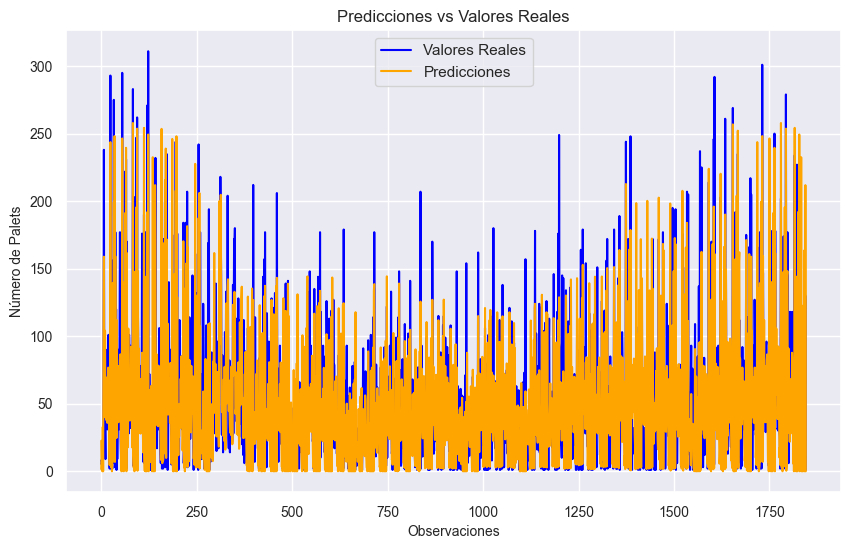

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test2.reset_index(drop=True), label='Valores Reales', color='blue')
plt.plot(y_pred2, label='Predicciones', color='orange')
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Observaciones')
plt.ylabel('Número de Palets')
plt.legend()
plt.show()

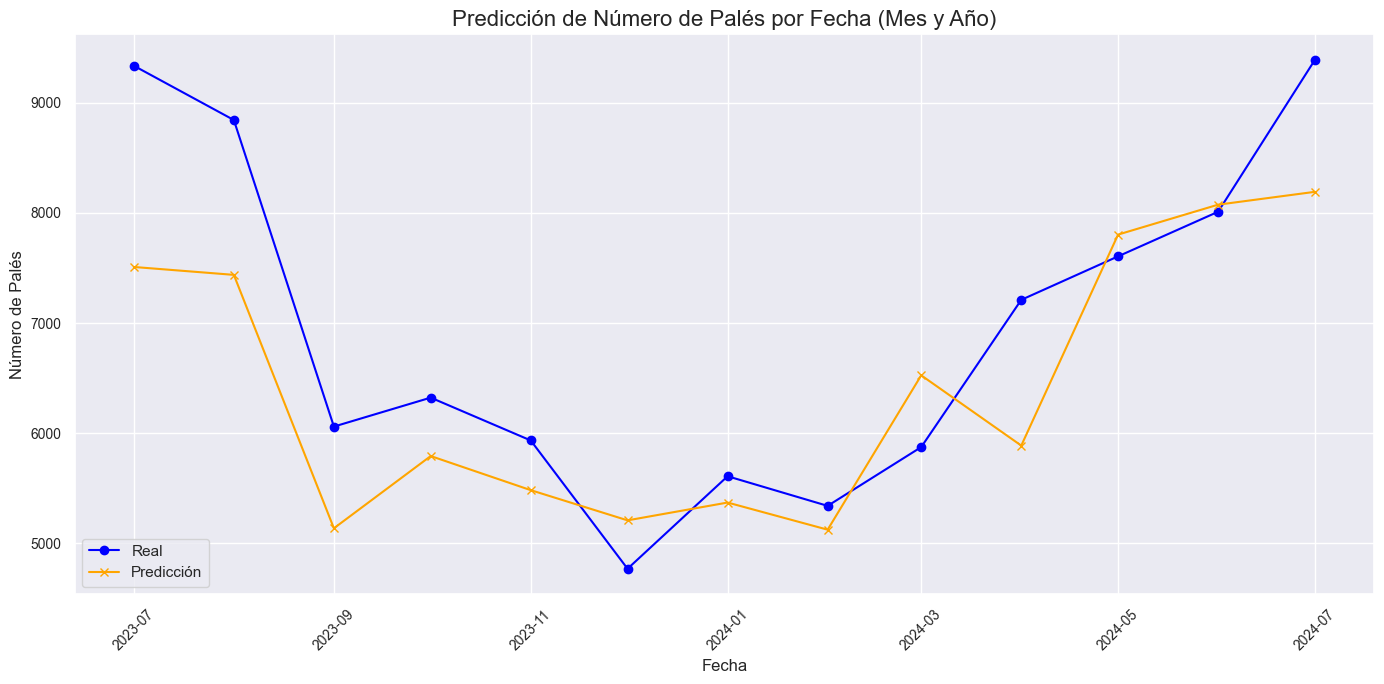

In [ ]:
real_vs_pred_mes = pd.DataFrame({
    'fecha': pd.to_datetime(X_test3['ano'].astype(str) + '-' + X_test3['mes'].astype(str) + '-01', format='%Y-%m-%d'),
    'numero_pales': y_test3.values,
    'predicted_pales': y_pred3
})


real_vs_pred_mes_grouped = real_vs_pred_mes.groupby('fecha').sum().reset_index()

plt.figure(figsize=(14, 7))

plt.plot(real_vs_pred_mes_grouped['fecha'], real_vs_pred_mes_grouped['numero_pales'], label='Real', color='blue', marker='o', linestyle='-')
plt.plot(real_vs_pred_mes_grouped['fecha'], real_vs_pred_mes_grouped['predicted_pales'], label='Predicción', color='orange', marker='x', linestyle='-')

plt.title('Predicción de Número de Palés por Fecha (Mes y Año)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Palés', fontsize=12)

plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

**Se guarda el modelo en un pickle**

In [ ]:
model_name = "model_mes"

with open(f"{model_name}.dat", "wb") as file:
    pickle.dump(model_mes, file)

print(f"{model_name}.dat")

model_mes.dat


In [ ]:
with open("model_mes.dat", "rb") as file:
    model_mes = pickle.load(file)

In [ ]:
X_train3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ano                            908 non-null    int32  
 1   mes                            908 non-null    int32  
 2   transporte_destino             908 non-null    int32  
 3   id_tipo_transporte_freq        908 non-null    float64
 4   region_destino_final_freq      908 non-null    float64
 5   promedio_numero_pales_mensual  908 non-null    float64
dtypes: float64(3), int32(3)
memory usage: 32.1 KB


#### Prediccion mensual con el model_mes

In [ ]:
df_prediccion_mes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 918 entries, 0 to 24989
Data columns (total 7 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ano                                        918 non-null    int32  
 1   mes                                        918 non-null    int32  
 2   transporte_destino                         918 non-null    int32  
 3   region_destino_final_freq                  918 non-null    float64
 4   id_tipo_transporte_freq                    918 non-null    float64
 5   promedio_numero_pales_mensual              918 non-null    float64
 6   promedio_envios_diario_transporte_destino  918 non-null    float64
dtypes: float64(4), int32(3)
memory usage: 46.6 KB


In [ ]:
df_prediccion_mensual = df_prediccion_mes.copy()

In [ ]:
df_prediccion_mensual.drop(columns=['promedio_envios_diario_transporte_destino'], inplace=True)

Es necesario ordenar las columnas para el modelo

In [ ]:
nuevo_orden = [
    'ano',
    'mes',
    'transporte_destino',
    'id_tipo_transporte_freq',
    'region_destino_final_freq',
    'promedio_numero_pales_mensual'
]

In [ ]:
df_prediccion_mensual = df_prediccion_mensual[nuevo_orden]

Se predice en base al dataframe **prediccion para el 2024-2025** la variable numero_pales

In [ ]:
df_prediccion_mensual['numero_pales'] = model_mes.predict(df_prediccion_mensual)
df_prediccion_mensual['numero_pales'] = np.maximum(df_prediccion_mensual['numero_pales'], 0)

In [ ]:
df_prediccion_mensual

,ano,mes,transporte_destino,id_tipo_transporte_freq,region_destino_final_freq,promedio_numero_pales_mensual,numero_pales
0,2024,7,14,0.457827,0.075998,8541.0,117.600605
1,2024,7,5,0.457827,0.081768,8541.0,249.941695
2,2024,7,20,0.457827,0.119705,8541.0,116.133053
3,2024,7,17,0.457827,0.120156,8541.0,198.764652
4,2024,7,24,0.457827,0.157929,8541.0,337.615112
...,...,...,...,...,...,...,...
24985,2025,12,0,0.000082,0.000205,4330.0,147.211282
24986,2025,12,29,0.541968,0.002947,4330.0,0.000000
24987,2025,12,45,0.541968,0.003438,4330.0,0.000000
24988,2025,12,1,0.457827,0.021608,4330.0,506.330762


In [ ]:
df_prediccion_mensual = df_prediccion_mensual.merge(df_provincias[['provincia_destino_final', 'region_destino_final','id_tipo_transporte', 'transporte_destino']],
                                    on=['transporte_destino'],
                                    how='left')

In [ ]:
df_prediccion_mensual.drop(columns=['region_destino_final_freq'],axis= 1,inplace=True)
df_prediccion_mensual.drop(columns=['id_tipo_transporte_freq'],axis= 1,inplace=True)
df_prediccion_mensual.drop(columns=['transporte_destino'],axis= 1,inplace=True)
df_prediccion_mensual.drop(columns=['promedio_numero_pales_mensual'],axis= 1,inplace=True)

In [ ]:
df_prediccion_mensual.head()

,ano,mes,numero_pales,provincia_destino_final,region_destino_final,id_tipo_transporte
0,2024,7,117.600605,Cantabria,39,1
1,2024,7,249.941695,Guadalajara,19,1
2,2024,7,116.133053,Valencia,46,1
3,2024,7,198.764652,Sevilla,41,1
4,2024,7,337.615112,Barcelona,8,1


In [ ]:
df_prediccion_mensual.to_csv('df_prediccion_mensual_lgbm.csv', index=False)

print("El DataFrame se ha guardado en 'df_prediccion_mensual_lgbm.csv'")

El DataFrame se ha guardado en 'df_prediccion_mensual_lgbm.csv'


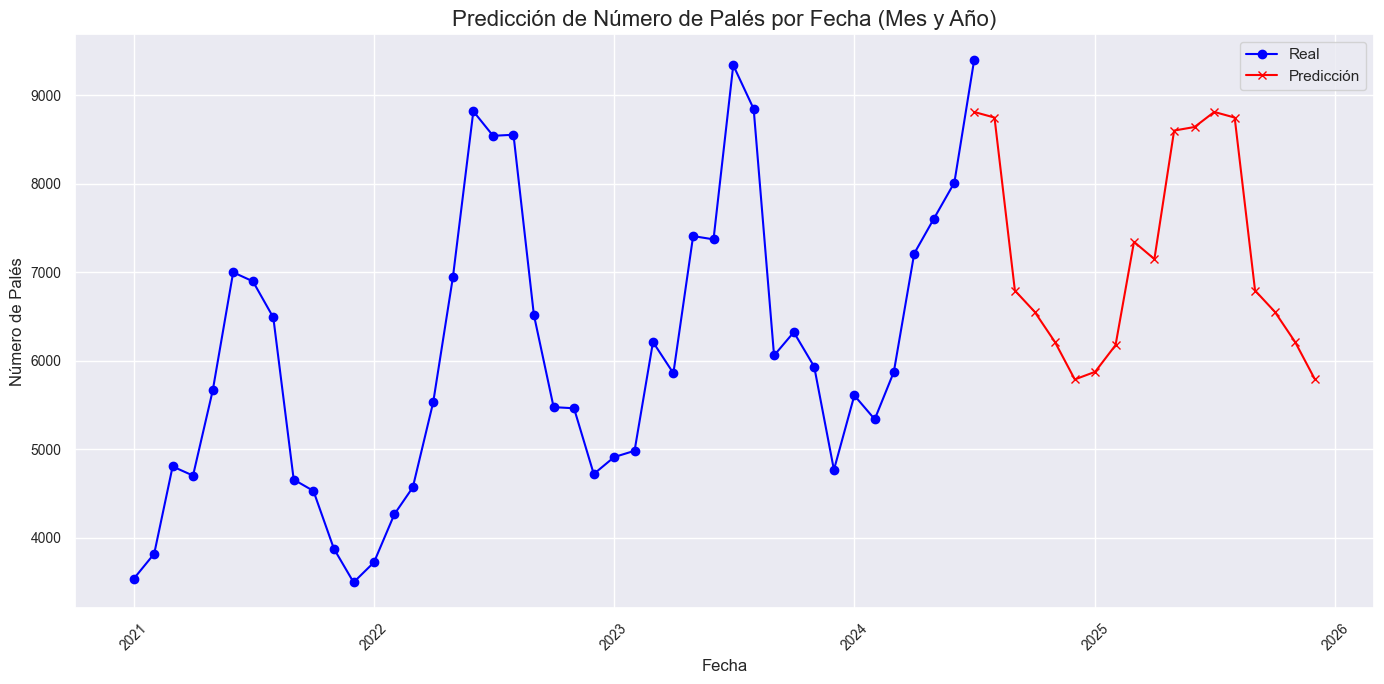

In [ ]:
df_historico_mensual = df_final[df_final['ano'] <= 2024].groupby(['ano', 'mes']).agg({'numero_pales': 'sum'}).reset_index()

df_prediccion_mensual_grouped = df_prediccion_mensual[df_prediccion_mensual['ano'] >= 2024].groupby(['ano', 'mes']).agg({'numero_pales': 'sum'}).reset_index()

df_historico_mensual['Fecha'] = pd.to_datetime(df_historico_mensual['ano'].astype(str) + '-' + df_historico_mensual['mes'].astype(str), format='%Y-%m')
df_prediccion_mensual_grouped['Fecha'] = pd.to_datetime(df_prediccion_mensual_grouped['ano'].astype(str) + '-' + df_prediccion_mensual_grouped['mes'].astype(str), format='%Y-%m')

plt.figure(figsize=(14, 7))

plt.plot(df_historico_mensual['Fecha'], df_historico_mensual['numero_pales'], label='Real', marker='o', color='blue')
plt.plot(df_prediccion_mensual_grouped['Fecha'], df_prediccion_mensual_grouped['numero_pales'], label='Predicción', marker='x', color='red')

plt.title('Predicción de Número de Palés por Fecha (Mes y Año)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Palés', fontsize=12)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4.4 Xgboost Semanal

Se reutilizan los dataframes semanal de train y test definidos previamente

In [ ]:
df_envios_semanaltrain

,ano,mes,semana,transporte_destino,id_tipo_transporte_freq,region_destino_final_freq,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales
0,2021,1,1,2,0.457827,0.049355,4447.0,838.0,62
1,2021,1,1,5,0.457827,0.081768,4447.0,838.0,65
2,2021,1,1,9,0.457827,0.136853,4447.0,838.0,48
3,2021,1,1,12,0.457827,0.071741,4447.0,838.0,42
4,2021,1,1,14,0.457827,0.075998,4447.0,838.0,31
...,...,...,...,...,...,...,...,...,...
3741,2023,6,26,43,0.541968,0.023450,7800.0,1780.0,4
3742,2023,6,26,44,0.541968,0.119705,7800.0,1780.0,149
3743,2023,6,26,47,0.541968,0.020544,7800.0,1780.0,3
3744,2023,6,26,48,0.541968,0.157929,7800.0,1780.0,151


In [ ]:
df_envios_semanaltest

,ano,mes,semana,transporte_destino,id_tipo_transporte_freq,region_destino_final_freq,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales
0,2023,7,26,5,0.457827,0.081768,8541.0,1780.0,8
1,2023,7,26,14,0.457827,0.075998,8541.0,1780.0,5
2,2023,7,26,17,0.457827,0.120156,8541.0,1780.0,6
3,2023,7,26,20,0.457827,0.119705,8541.0,1780.0,4
4,2023,7,26,24,0.457827,0.157929,8541.0,1780.0,6
...,...,...,...,...,...,...,...,...,...
1841,2024,7,31,44,0.541968,0.119705,8541.0,1667.0,104
1842,2024,7,31,45,0.541968,0.003438,8541.0,1667.0,1
1843,2024,7,31,47,0.541968,0.020544,8541.0,1667.0,22
1844,2024,7,31,48,0.541968,0.157929,8541.0,1667.0,130


Tanto del data frame Train y Test quitamos la variable objetivo, en este caso **numero_pales**

In [ ]:
X_train4= df_envios_semanaltrain.drop(columns=['numero_pales'])
X_test4 =df_envios_semanaltest.drop(columns=['numero_pales'])
y_train4 = df_envios_semanaltrain['numero_pales']
y_test4 = df_envios_semanaltest['numero_pales']

In [ ]:
X_train4

,ano,mes,semana,transporte_destino,id_tipo_transporte_freq,region_destino_final_freq,promedio_numero_pales_mensual,promedio_numero_pales_semanal
0,2021,1,1,2,0.457827,0.049355,4447.0,838.0
1,2021,1,1,5,0.457827,0.081768,4447.0,838.0
2,2021,1,1,9,0.457827,0.136853,4447.0,838.0
3,2021,1,1,12,0.457827,0.071741,4447.0,838.0
4,2021,1,1,14,0.457827,0.075998,4447.0,838.0
...,...,...,...,...,...,...,...,...
3741,2023,6,26,43,0.541968,0.023450,7800.0,1780.0
3742,2023,6,26,44,0.541968,0.119705,7800.0,1780.0
3743,2023,6,26,47,0.541968,0.020544,7800.0,1780.0
3744,2023,6,26,48,0.541968,0.157929,7800.0,1780.0


Establecemos los parámetros que recibirá nuestro modelo **XGBOOST**

In [ ]:
model_semanal_xgb = xgb.XGBRegressor(
   colsample_bytree=0.8,
    learning_rate=0.005,
    max_depth=6,
    n_estimators=3000,
    reg_alpha=2.0,
    reg_lambda=2.0,
    subsample=0.7,
    min_child_weight=10
)

Probamos estos parametros haciendo validación cruzada

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
scores = cross_val_score(
    model_semanal_xgb,
    X_train4,
    y_train4,
    cv=kfold,
    scoring='neg_mean_squared_error'
)

In [ ]:
rmse_scores = (-scores) ** 0.5

print(f"RMSE por cada fold: {rmse_scores}")
print(f"RMSE promedio: {rmse_scores.mean()}")
print(f"Desviación estándar de RMSE: {rmse_scores.std()}")

RMSE por cada fold: [25.57271963 25.89068748 25.35498678 28.646467   25.10804177]
RMSE promedio: 26.114580530214198
Desviación estándar de RMSE: 1.2918431310428091


Implementamos el **model_semanal_xgb** , que recibe los parámetros definidos anteriormente

In [ ]:
# Se entrena el modelo
model_semanal_xgb.fit(X_train4, y_train4)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Se hacen predicciones en el conjunto de prueba
y_pred4 = model_semanal_xgb.predict(X_test4)
y_pred4[y_pred4 < 0] = 0

**Obtenemos las métricas para analizar el modelo y sus resultados**

In [ ]:
y_pred_train4 = model_semanal_xgb.predict(X_train4)

rmse_train4 = np.sqrt(mean_squared_error(y_train4, y_pred_train4))
mae_train4 = mean_absolute_error(y_train4, y_pred_train4)
r2_train4 = r2_score(y_train4, y_pred_train4)

rmse_test4 = np.sqrt(mean_squared_error(y_test4, y_pred4))
mae_test4 = mean_absolute_error(y_test4, y_pred4)
r2_test4 = r2_score(y_test4, y_pred4)

print(f'Métricas para el modelo:')
print(f"MAE_train: {mae_train4:.2f}, Train RMSE: {rmse_train4:.2f},R²_train: {r2_train4:.2f} ")
print(f"MAE_test: {mae_test4:.2f}, Test RMSE: {rmse_test4:.2f}, R²_test:{r2_test4:.2f} ")

Métricas para el modelo:
MAE_train: 13.48, Train RMSE: 20.12,R²_train: 0.85 
MAE_test: 20.06, Test RMSE: 30.34, R²_test:0.68 


Graficamos los datos **Reales** vs **Prediccion** para visualizar que tan bien está prediciendo el modelo

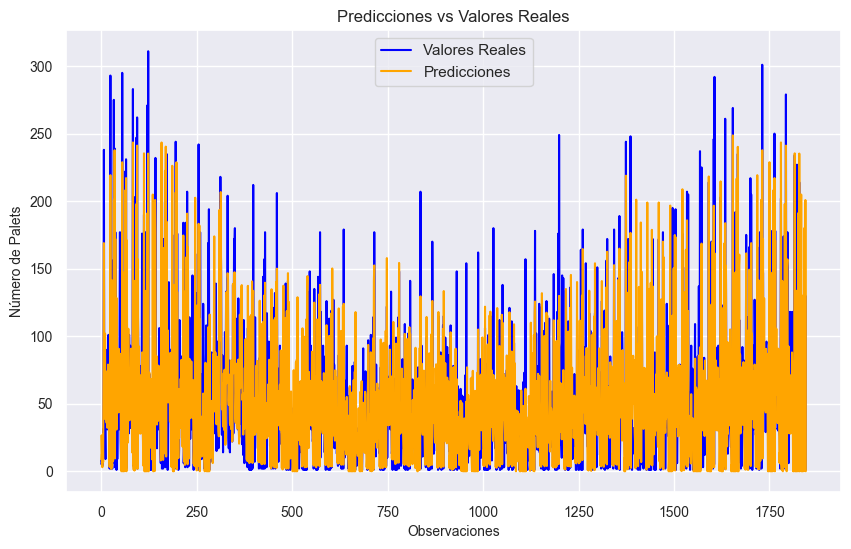

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test4.reset_index(drop=True), label='Valores Reales', color='blue')
plt.plot(y_pred4, label='Predicciones', color='orange')
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Observaciones')
plt.ylabel('Número de Palets')
plt.legend()
plt.show()


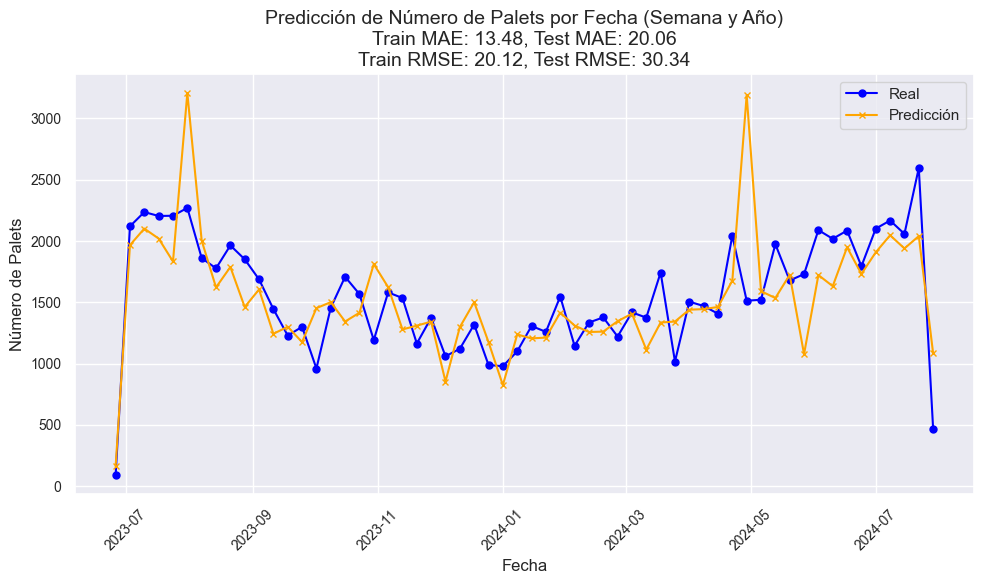

In [ ]:
X_test4['fecha'] = pd.to_datetime(X_test4['ano'].astype(str) + '-W' + X_test4['semana'].astype(str) + '-1', format='%Y-W%W-%w')


real_vs_pred_semanal_xgb = pd.DataFrame({
    'fecha': X_test4['fecha'],
    'numero_pales': y_test4.values,
    'predicted_pales': y_pred4,
    'zona_destino': X_test4['region_destino_final_freq'],
    'tipo_transporte': X_test4['id_tipo_transporte_freq']
})

real_vs_pred_agrupado_xgb = real_vs_pred_semanal_xgb.groupby(['fecha']).sum().reset_index()

plt.figure(figsize=(10, 6))

plt.plot(real_vs_pred_agrupado_xgb['fecha'], real_vs_pred_agrupado_xgb['numero_pales'], label='Real', marker='o', color='blue', markersize=5)
plt.plot(real_vs_pred_agrupado_xgb['fecha'], real_vs_pred_agrupado_xgb['predicted_pales'], label='Predicción', marker='x', color='orange', markersize=5)

plt.title(f"Predicción de Número de Palets por Fecha (Semana y Año)\nTrain MAE: {mae_train4:.2f}, Test MAE: {mae_test4:.2f}\nTrain RMSE: {rmse_train4:.2f}, Test RMSE: {rmse_test4:.2f}", fontsize=14)

plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Palets', fontsize=12)

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

**Se guarda el modelo en un pickle**

In [ ]:
model_name = "model_semanal_xgb"

with open(f"{model_name}.dat", "wb") as file:
    pickle.dump(model_semanal_xgb, file)

print(f"{model_name}.dat")

model_semanal_xgb.dat


In [ ]:
with open("model_semanal_xgb.dat", "rb") as file:
    model_semanal_xgb = pickle.load(file)

#### Prediccion semanal con el model_semanal_xgb

In [ ]:
df_prediccion_semanal_xgb = df_pred_semanal[[ 'ano', 'mes','semana','transporte_destino', 'region_destino_final_freq',
                 'id_tipo_transporte_freq','promedio_numero_pales_semanal','promedio_numero_pales_mensual']].drop_duplicates(subset=['transporte_destino', 'ano', 'mes','semana'])


In [ ]:
df_prediccion_semanal_xgb

,ano,mes,semana,transporte_destino,region_destino_final_freq,id_tipo_transporte_freq,promedio_numero_pales_semanal,promedio_numero_pales_mensual
0,2024,7,31,14,0.075998,0.457827,1667.0,8541.0
1,2024,7,31,5,0.081768,0.457827,1667.0,8541.0
2,2024,7,31,20,0.119705,0.457827,1667.0,8541.0
3,2024,7,31,17,0.120156,0.457827,1667.0,8541.0
4,2024,7,31,24,0.157929,0.457827,1667.0,8541.0
...,...,...,...,...,...,...,...,...
26413,2025,12,1,0,0.000205,0.000082,838.0,4330.0
26414,2025,12,1,29,0.002947,0.541968,838.0,4330.0
26415,2025,12,1,45,0.003438,0.541968,838.0,4330.0
26416,2025,12,1,1,0.021608,0.457827,838.0,4330.0


In [ ]:
X_train4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3746 entries, 0 to 3745
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ano                            3746 non-null   int32  
 1   mes                            3746 non-null   int32  
 2   semana                         3746 non-null   UInt32 
 3   transporte_destino             3746 non-null   int32  
 4   id_tipo_transporte_freq        3746 non-null   float64
 5   region_destino_final_freq      3746 non-null   float64
 6   promedio_numero_pales_mensual  3746 non-null   float64
 7   promedio_numero_pales_semanal  3746 non-null   float64
dtypes: UInt32(1), float64(4), int32(3)
memory usage: 179.4 KB


Es necesario ordenar las columnas para el modelo

In [ ]:
df_prediccion_semanal_xgb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4590 entries, 0 to 26417
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ano                            4590 non-null   int32  
 1   mes                            4590 non-null   int32  
 2   semana                         4590 non-null   UInt32 
 3   transporte_destino             4590 non-null   int32  
 4   region_destino_final_freq      4590 non-null   float64
 5   id_tipo_transporte_freq        4590 non-null   float64
 6   promedio_numero_pales_semanal  4590 non-null   float64
 7   promedio_numero_pales_mensual  4590 non-null   float64
dtypes: UInt32(1), float64(4), int32(3)
memory usage: 255.5 KB


In [ ]:
nuevo_orden = [
    'ano',
    'mes',
     'semana',
    'transporte_destino',
    'id_tipo_transporte_freq',
    'region_destino_final_freq',
    'promedio_numero_pales_mensual',
    'promedio_numero_pales_semanal',
]

In [ ]:
df_prediccion_semanal_xgb = df_prediccion_semanal_xgb[nuevo_orden]

Se predice en base al dataframe **prediccion para el 2024-2025** la variable numero_pales

In [ ]:
df_prediccion_semanal_xgb['numero_pales'] = model_semanal_xgb.predict(df_prediccion_semanal_xgb)
df_prediccion_semanal_xgb['numero_pales'] = np.maximum(df_prediccion_semanal_xgb['numero_pales'], 0)

C:\Users\usuario\AppData\Local\Temp\ipykernel_9932\1916862841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediccion_semanal_xgb['numero_pales'] = model_semanal_xgb.predict(df_prediccion_semanal_xgb)
C:\Users\usuario\AppData\Local\Temp\ipykernel_9932\1916862841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediccion_semanal_xgb['numero_pales'] = np.maximum(df_prediccion_semanal_xgb['numero_pales'], 0)


In [ ]:
df_prediccion_semanal_xgb

,ano,mes,semana,transporte_destino,id_tipo_transporte_freq,region_destino_final_freq,promedio_numero_pales_mensual,promedio_numero_pales_semanal,numero_pales
0,2024,7,31,14,0.457827,0.075998,8541.0,1667.0,21.830332
1,2024,7,31,5,0.457827,0.081768,8541.0,1667.0,43.213734
2,2024,7,31,20,0.457827,0.119705,8541.0,1667.0,17.463682
3,2024,7,31,17,0.457827,0.120156,8541.0,1667.0,35.173260
4,2024,7,31,24,0.457827,0.157929,8541.0,1667.0,56.792744
...,...,...,...,...,...,...,...,...,...
26413,2025,12,1,0,0.000082,0.000205,4330.0,838.0,52.715343
26414,2025,12,1,29,0.541968,0.002947,4330.0,838.0,0.000000
26415,2025,12,1,45,0.541968,0.003438,4330.0,838.0,0.000000
26416,2025,12,1,1,0.457827,0.021608,4330.0,838.0,104.536682


In [ ]:
df_prediccion_semanal_xgb = df_prediccion_semanal_xgb.merge(df_provincias[['provincia_destino_final', 'region_destino_final','id_tipo_transporte', 'transporte_destino']],
                                    on=['transporte_destino'],
                                    how='left')

In [ ]:
df_prediccion_semanal_xgb.drop(columns=['region_destino_final_freq'],axis= 1,inplace=True)
df_prediccion_semanal_xgb.drop(columns=['id_tipo_transporte_freq'],axis= 1,inplace=True)
df_prediccion_semanal_xgb.drop(columns=['transporte_destino'],axis= 1,inplace=True)
df_prediccion_semanal_xgb.drop(columns=['promedio_numero_pales_semanal'],axis= 1,inplace=True)
df_prediccion_semanal_xgb.drop(columns=['promedio_numero_pales_mensual'],axis= 1,inplace=True)

In [ ]:
df_prediccion_semanal_xgb.head()

,ano,mes,semana,numero_pales,provincia_destino_final,region_destino_final,id_tipo_transporte
0,2024,7,31,21.830332,Cantabria,39,1
1,2024,7,31,43.213734,Guadalajara,19,1
2,2024,7,31,17.463682,Valencia,46,1
3,2024,7,31,35.173260,Sevilla,41,1
4,2024,7,31,56.792744,Barcelona,8,1


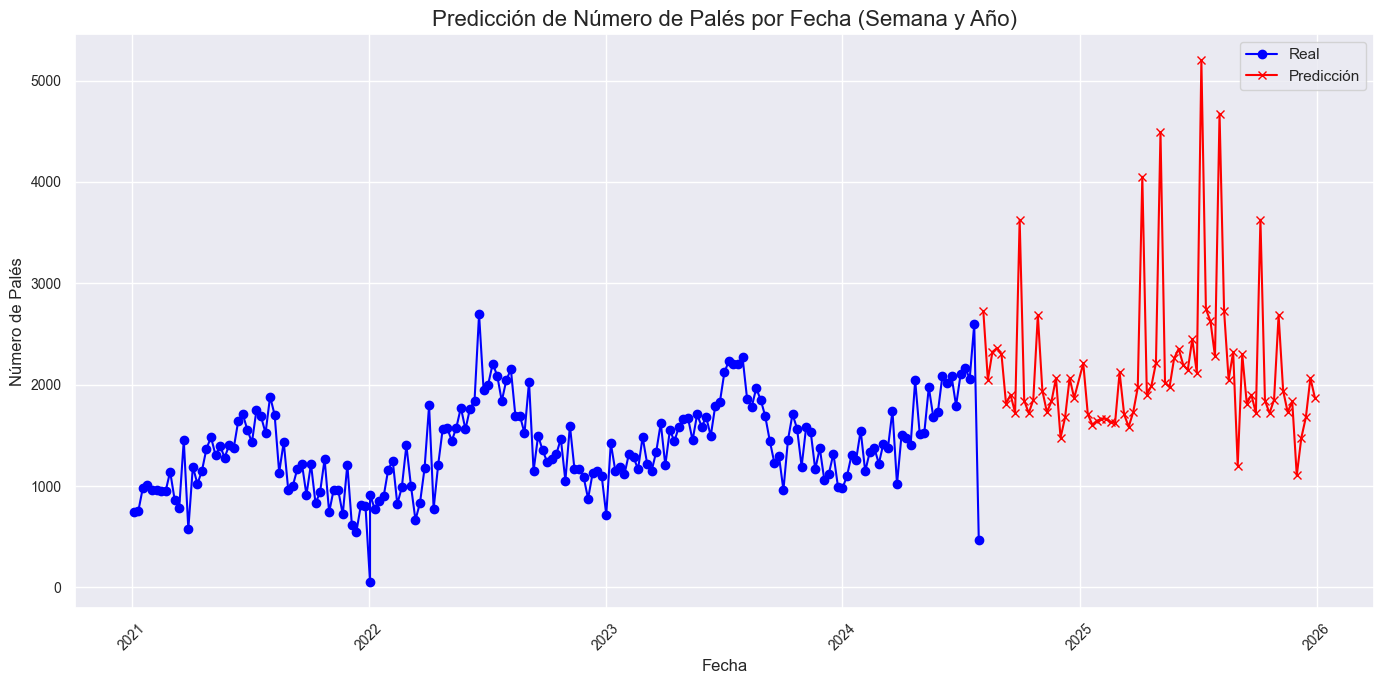

In [ ]:
df_prediccion_semanal_copy = df_prediccion_semanal_xgb.copy()

df_prediccion_semanal_grouped = df_prediccion_semanal_copy.groupby(['ano', 'semana']).agg({'numero_pales': 'sum'}).reset_index()

df_prediccion_semanal_grouped['Fecha'] = pd.to_datetime(df_prediccion_semanal_grouped['ano'].astype(str) + df_prediccion_semanal_grouped['semana'].astype(str) + '1', format='%Y%W%w')

fecha_maxima_real = df_final['fecha'].max()

df_historico_semanal = df_final[df_final['fecha'] <= fecha_maxima_real].groupby(['ano', 'semana']).agg({'numero_pales': 'sum'}).reset_index()
df_historico_semanal['Fecha'] = pd.to_datetime(df_historico_semanal['ano'].astype(str) + df_historico_semanal['semana'].astype(str) + '1', format='%Y%W%w')

df_prediccion_semanal_grouped = df_prediccion_semanal_grouped[df_prediccion_semanal_grouped['Fecha'] > fecha_maxima_real]

plt.figure(figsize=(14, 7))

plt.plot(df_historico_semanal['Fecha'], df_historico_semanal['numero_pales'], label='Real', marker='o', color='blue')
plt.plot(df_prediccion_semanal_grouped['Fecha'], df_prediccion_semanal_grouped['numero_pales'], label='Predicción', marker='x', color='red')

plt.title('Predicción de Número de Palés por Fecha (Semana y Año)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Palés', fontsize=12)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_prediccion_semanal_xgb.to_csv('df_prediccion_semanal_xgb.csv', index=False)

print("El DataFrame se ha guardado en 'df_prediccion_semanal_xgb.csv'")

El DataFrame se ha guardado en 'df_prediccion_semanal_xgb.csv'


### 4.5 Xgboost Mensual


Reutilizamos el dataframe de mes train y test definidos anteriormente

In [ ]:
df_enviosmestrain

,ano,mes,transporte_destino,id_tipo_transporte_freq,region_destino_final_freq,promedio_numero_pales_mensual,numero_pales
0,2021,1,2,0.457827,0.049355,4447.0,356
1,2021,1,5,0.457827,0.081768,4447.0,222
2,2021,1,7,0.457827,0.008758,4447.0,2
3,2021,1,8,0.457827,0.000205,4447.0,1
4,2021,1,9,0.457827,0.136853,4447.0,240
...,...,...,...,...,...,...,...
903,2023,6,43,0.541968,0.023450,7800.0,14
904,2023,6,44,0.541968,0.119705,7800.0,729
905,2023,6,47,0.541968,0.020544,7800.0,15
906,2023,6,48,0.541968,0.157929,7800.0,830


In [ ]:
df_enviosmestrain = df_train_mes.groupby(['ano', 'mes', 'transporte_destino','id_tipo_transporte_freq','region_destino_final_freq','promedio_numero_pales_mensual']).agg(
    numero_pales=('numero_pales', 'sum')
).reset_index()

df_enviosmestest = df_test_mes.groupby(['ano', 'mes', 'transporte_destino','id_tipo_transporte_freq','region_destino_final_freq','promedio_numero_pales_mensual']).agg(
    numero_pales=('numero_pales', 'sum')
).reset_index()


Tanto del data frame Train y Test quitamos la variable objetivo, en este caso **numero_pales**

In [ ]:
X_train5= df_enviosmestrain.drop(columns=['numero_pales'])
X_test5 =df_enviosmestest.drop(columns=['numero_pales'])
y_train5 = df_enviosmestrain['numero_pales']
y_test5 = df_enviosmestest['numero_pales']

In [ ]:
X_train5

,ano,mes,transporte_destino,id_tipo_transporte_freq,region_destino_final_freq,promedio_numero_pales_mensual
0,2021,1,2,0.457827,0.049355,4447.0
1,2021,1,5,0.457827,0.081768,4447.0
2,2021,1,7,0.457827,0.008758,4447.0
3,2021,1,8,0.457827,0.000205,4447.0
4,2021,1,9,0.457827,0.136853,4447.0
...,...,...,...,...,...,...
903,2023,6,43,0.541968,0.023450,7800.0
904,2023,6,44,0.541968,0.119705,7800.0
905,2023,6,47,0.541968,0.020544,7800.0
906,2023,6,48,0.541968,0.157929,7800.0


In [ ]:
y_train5.head()

0    356
1    222
2      2
3      1
4    240
Name: numero_pales, dtype: int64

Establecemos los parámetros que recibirá nuestro modelo **XGBOOST**

In [ ]:
model_mes_xgb = xgb.XGBRegressor(
   colsample_bytree=0.8,
    learning_rate=0.005,
    max_depth=6,
    n_estimators=3000,
    reg_alpha=2.0,
    reg_lambda=2.0,
    subsample=0.7,
    min_child_weight=10
)

Hacemos validación cruzada para saber si nuestros parámetros estan funcionando correctamente

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
scores = cross_val_score(
    model_mes_xgb,
    X_train5,
    y_train5,
    cv=kfold,
    scoring='neg_mean_squared_error'
)

In [ ]:
rmse_scores = (-scores) ** 0.5

print(f"RMSE por cada fold: {rmse_scores}")
print(f"RMSE promedio: {rmse_scores.mean()}")
print(f"Desviación estándar de RMSE: {rmse_scores.std()}")

RMSE por cada fold: [52.66413827 70.16743656 66.39073835 69.83742232 53.94500092]
RMSE promedio: 62.600947286166274
Desviación estándar de RMSE: 7.715522380909662


In [ ]:
# Se entrena el modelo
model_mes_xgb.fit(X_train5, y_train5)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Se hacen predicciones en el conjunto de prueba
y_pred5 = model_mes_xgb.predict(X_test5)
y_pred5[y_pred5 < 0] = 0

**Obtenemos las métricas para analizar el modelo y sus resultados**

In [ ]:
y_pred_train5 = model_mes.predict(X_train5)

rmse_train5 = np.sqrt(mean_squared_error(y_train5, y_pred_train5))
mae_train5 = mean_absolute_error(y_train5, y_pred_train5)
r2_train5 = r2_score(y_train5, y_pred_train5)

rmse_test5 = np.sqrt(mean_squared_error(y_test5, y_pred5))
mae_test5 = mean_absolute_error(y_test5, y_pred5)
r2_test5 = r2_score(y_test5, y_pred5)

print(f'Métricas para el modelo:')
print(f"MAE_train: {mae_train5:.2f}, Train RMSE: {rmse_train5:.2f},R²_train: {r2_train5:.2f} ")
print(f"MAE_test: {mae_test5:.2f}, Test RMSE: {rmse_test5:.2f}, R²_test:{r2_test5:.2f} ")

Métricas para el modelo:
MAE_train: 25.53, Train RMSE: 40.30,R²_train: 0.96 
MAE_test: 61.82, Test RMSE: 99.58, R²_test:0.80 


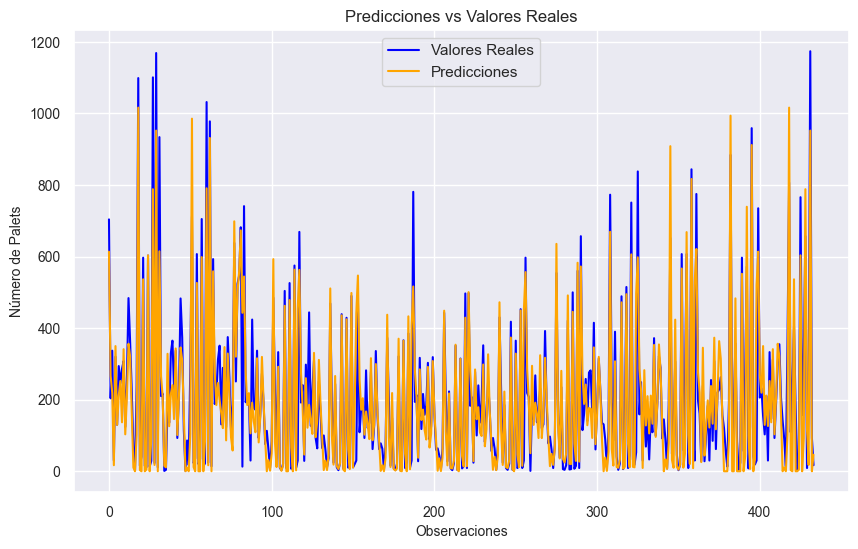

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test5.reset_index(drop=True), label='Valores Reales', color='blue')
plt.plot(y_pred5, label='Predicciones', color='orange')
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Observaciones')
plt.ylabel('Número de Palets')
plt.legend()
plt.show()


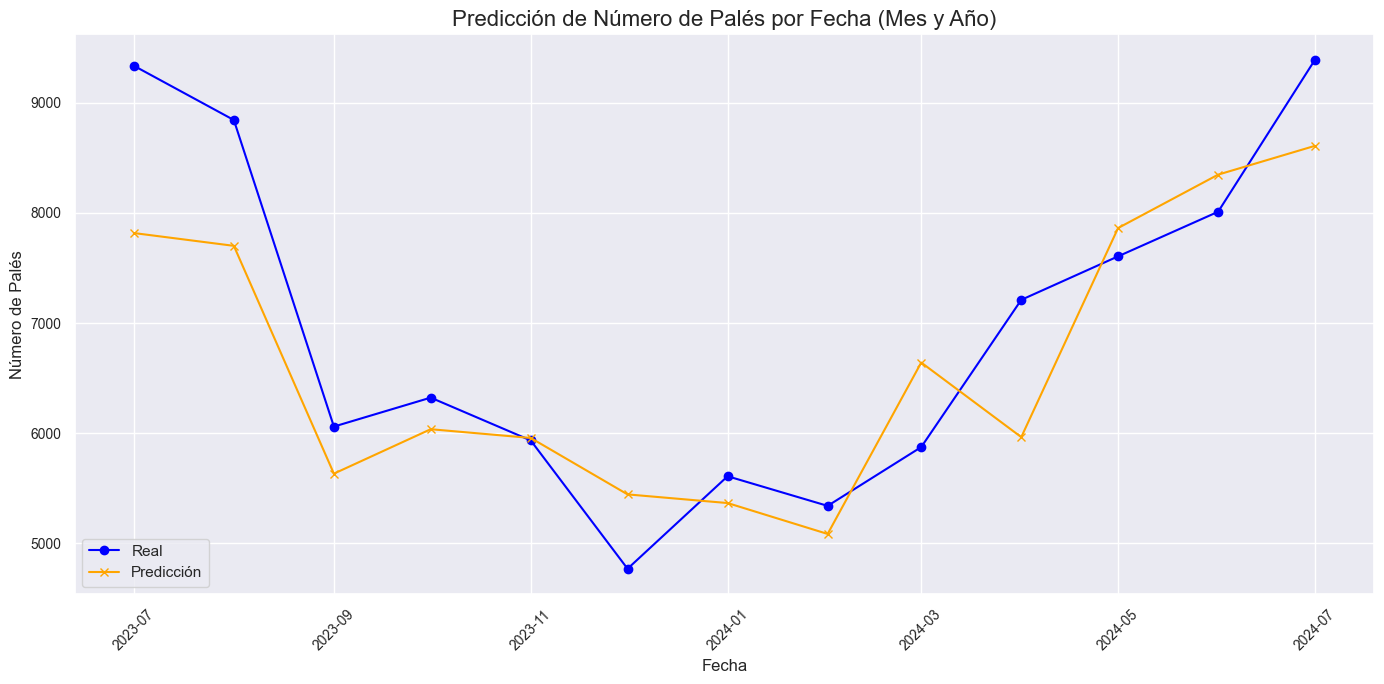

In [ ]:
real_vs_pred_mes_xgb = pd.DataFrame({
    'fecha': pd.to_datetime(X_test5['ano'].astype(str) + '-' + X_test5['mes'].astype(str) + '-01', format='%Y-%m-%d'),
    'numero_pales': y_test5.values,
    'predicted_pales': y_pred5
})

real_vs_pred_mes_grouped_xgb = real_vs_pred_mes_xgb.groupby('fecha').sum().reset_index()

plt.figure(figsize=(14, 7))

plt.plot(real_vs_pred_mes_grouped_xgb['fecha'], real_vs_pred_mes_grouped_xgb['numero_pales'], label='Real', color='blue', marker='o', linestyle='-')
plt.plot(real_vs_pred_mes_grouped_xgb['fecha'], real_vs_pred_mes_grouped_xgb['predicted_pales'], label='Predicción', color='orange', marker='x', linestyle='-')

plt.title('Predicción de Número de Palés por Fecha (Mes y Año)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Palés', fontsize=12)

plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()


**Se guarda el modelo en un pickle**

In [ ]:
model_name = "model_mes_xgb"

with open(f"{model_name}.dat", "wb") as file:
    pickle.dump(model_mes_xgb, file)

print(f"{model_name}.dat")

model_mes_xgb.dat


In [ ]:
with open("model_mes_xgb.dat", "rb") as file:
    model_mes_xgb = pickle.load(file)

#### Prediccion mensual con el model_mes_xgb

In [ ]:
df_prediccion_mes

,ano,mes,transporte_destino,region_destino_final_freq,id_tipo_transporte_freq,promedio_numero_pales_mensual,promedio_envios_diario_transporte_destino
0,2024,7,14,0.075998,0.457827,8541.0,1.808843
1,2024,7,5,0.081768,0.457827,8541.0,1.787190
2,2024,7,20,0.119705,0.457827,8541.0,1.617391
3,2024,7,17,0.120156,0.457827,8541.0,1.494324
4,2024,7,24,0.157929,0.457827,8541.0,1.875269
...,...,...,...,...,...,...,...
24985,2025,12,0,0.000205,0.000082,4330.0,1.000000
24986,2025,12,29,0.002947,0.541968,4330.0,1.000000
24987,2025,12,45,0.003438,0.541968,4330.0,1.000000
24988,2025,12,1,0.021608,0.457827,4330.0,1.000000


In [ ]:
df_prediccion_mensual_xgb= df_prediccion_mes.copy()

In [ ]:
df_prediccion_mensual_xgb.drop(columns=['promedio_envios_diario_transporte_destino'], inplace=True)

In [ ]:
nuevo_orden = [
    'ano',
    'mes',
    'transporte_destino',
    'id_tipo_transporte_freq',
    'region_destino_final_freq',
    'promedio_numero_pales_mensual'
]

In [ ]:
df_prediccion_mensual_xgb = df_prediccion_mensual_xgb[nuevo_orden]

In [ ]:
df_prediccion_mensual_xgb['numero_pales'] = model_mes_xgb.predict(df_prediccion_mensual_xgb)
df_prediccion_mensual_xgb['numero_pales'] = np.maximum(df_prediccion_mensual_xgb['numero_pales'], 0)

In [ ]:
df_prediccion_mensual_xgb

,ano,mes,transporte_destino,id_tipo_transporte_freq,region_destino_final_freq,promedio_numero_pales_mensual,numero_pales
0,2024,7,14,0.457827,0.075998,8541.0,129.485107
1,2024,7,5,0.457827,0.081768,8541.0,267.271790
2,2024,7,20,0.457827,0.119705,8541.0,136.830627
3,2024,7,17,0.457827,0.120156,8541.0,211.643295
4,2024,7,24,0.457827,0.157929,8541.0,356.402802
...,...,...,...,...,...,...,...
24985,2025,12,0,0.000082,0.000205,4330.0,185.074036
24986,2025,12,29,0.541968,0.002947,4330.0,1.004956
24987,2025,12,45,0.541968,0.003438,4330.0,49.094208
24988,2025,12,1,0.457827,0.021608,4330.0,442.028198


In [ ]:
df_prediccion_mensual_xgb = df_prediccion_mensual_xgb.merge(df_provincias[['provincia_destino_final', 'region_destino_final','id_tipo_transporte', 'transporte_destino']],
                                    on=['transporte_destino'],
                                    how='left')

In [ ]:
df_prediccion_mensual_xgb.drop(columns=['region_destino_final_freq'],axis= 1,inplace=True)
df_prediccion_mensual_xgb.drop(columns=['id_tipo_transporte_freq'],axis= 1,inplace=True)
df_prediccion_mensual_xgb.drop(columns=['transporte_destino'],axis= 1,inplace=True)
df_prediccion_mensual_xgb.drop(columns=['promedio_numero_pales_mensual'],axis= 1,inplace=True)

In [ ]:
df_prediccion_mensual_xgb

,ano,mes,numero_pales,provincia_destino_final,region_destino_final,id_tipo_transporte
0,2024,7,129.485107,Cantabria,39,1
1,2024,7,267.271790,Guadalajara,19,1
2,2024,7,136.830627,Valencia,46,1
3,2024,7,211.643295,Sevilla,41,1
4,2024,7,356.402802,Barcelona,8,1
...,...,...,...,...,...,...
913,2025,12,185.074036,Las Palmas,35,11
914,2025,12,1.004956,Granada,18,3
915,2025,12,49.094208,Valladolid,47,3
916,2025,12,442.028198,Álava,1,1


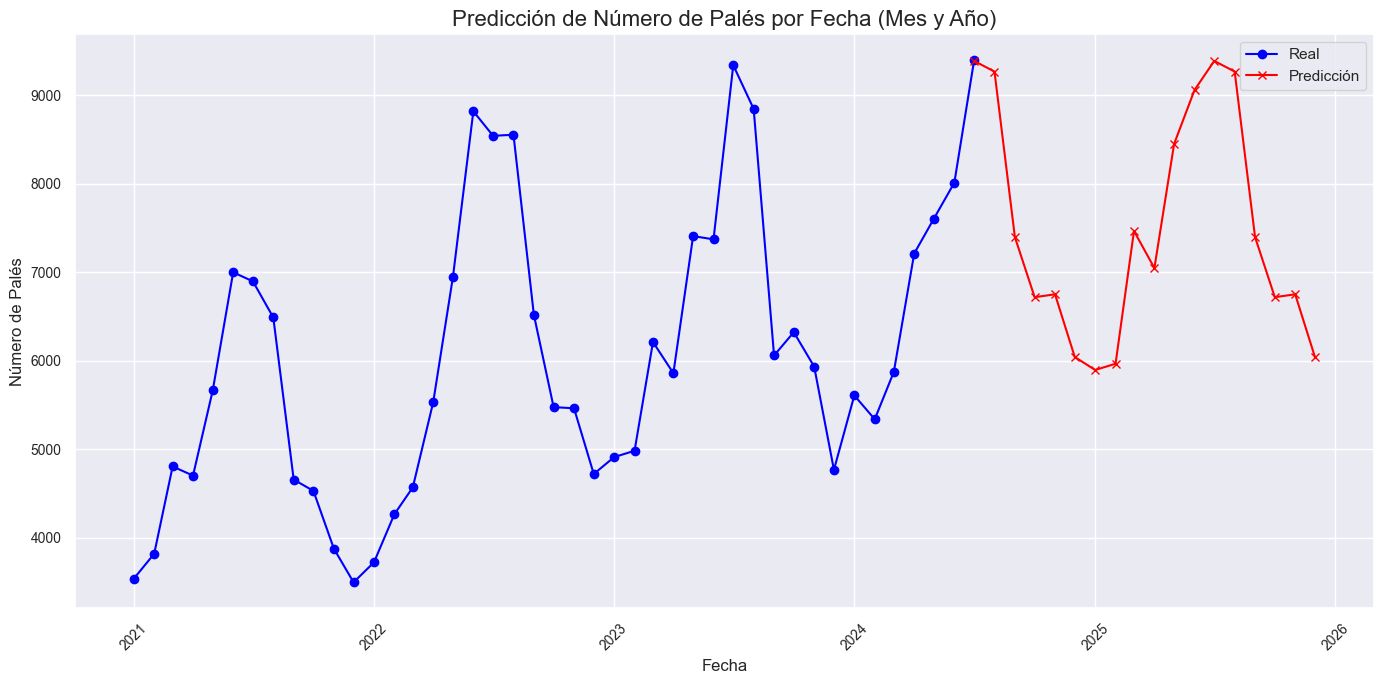

In [ ]:
df_historico_mensual = df_final[df_final['ano'] <= 2024].groupby(['ano', 'mes']).agg({'numero_pales': 'sum'}).reset_index()

df_prediccion_mensual_grouped = df_prediccion_mensual_xgb[df_prediccion_mensual_xgb['ano'] >= 2024].groupby(['ano', 'mes']).agg({'numero_pales': 'sum'}).reset_index()

df_historico_mensual['Fecha'] = pd.to_datetime(df_historico_mensual['ano'].astype(str) + '-' + df_historico_mensual['mes'].astype(str), format='%Y-%m')
df_prediccion_mensual_grouped['Fecha'] = pd.to_datetime(df_prediccion_mensual_grouped['ano'].astype(str) + '-' + df_prediccion_mensual_grouped['mes'].astype(str), format='%Y-%m')

plt.figure(figsize=(14, 7))

plt.plot(df_historico_mensual['Fecha'], df_historico_mensual['numero_pales'], label='Real', marker='o', color='blue')
plt.plot(df_prediccion_mensual_grouped['Fecha'], df_prediccion_mensual_grouped['numero_pales'], label='Predicción', marker='x', color='red')

plt.title('Predicción de Número de Palés por Fecha (Mes y Año)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Palés', fontsize=12)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df_prediccion_mensual_xgb.to_csv('df_prediccion_mensual_xgb.csv', index=False)

print("El DataFrame se ha guardado en 'df_prediccion_mensual_xgb.csv'")

El DataFrame se ha guardado en 'df_prediccion_mensual_xgb.csv'


In [ ]:
df_prediccion_semana

,ano,mes,semana,numero_pales,provincia_destino_final,region_destino_final,id_tipo_transporte
0,2024,7,31,6.799622,Cantabria,39,1
1,2024,7,31,32.930758,Guadalajara,19,1
2,2024,7,31,6.845968,Valencia,46,1
3,2024,7,31,23.595933,Sevilla,41,1
4,2024,7,31,63.209921,Barcelona,8,1
...,...,...,...,...,...,...,...
4585,2025,12,1,14.186728,Las Palmas,35,11
4586,2025,12,1,0.000000,Granada,18,3
4587,2025,12,1,0.000000,Valladolid,47,3
4588,2025,12,1,104.073413,Álava,1,1
